In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
import datetime
import numpy as np
import random
import seaborn as sns

Specifying all the focal brands

In [2]:
focal_brands = ['Sephora',
 'ULTA Beauty',
 'Olive Garden',
 'The Cheesecake Factory',
 'Target',
 'Walmart',
 'Anthropologie',
 "Victoria's Secret"]

Reading the social brands catalog to get visits later for each store

In [3]:
brands_visits = pd.read_csv('../data/revision_visits_revenue_2019.csv')
brands_visits['brand_standard'] = brands_visits['brand'].apply(lambda x: x.strip().lower()) # For comparison with catalog.tsv
brands_visits['date'] = brands_visits['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
brands_visits = brands_visits.rename(columns={'brand': 'brand_visitation'})
brands_visits.head()

,date,PLACEKEY,visits_by_day,spend_by_day,brand_visitation,lat,lon,brand_standard
0,2019-06-01,zzw-222@62j-sgj-q2k,5,0.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness
1,2019-06-02,zzw-222@62j-sgj-q2k,1,0.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness
2,2019-06-03,zzw-222@62j-sgj-q2k,6,859.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness
3,2019-06-04,zzw-222@62j-sgj-q2k,6,30.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness
4,2019-06-05,zzw-222@62j-sgj-q2k,8,193.0,Orangetheory Fitness,42.350592,-71.153024,orangetheory fitness


Reading Travel Time

In [4]:
with open('../data/travel_time.pkl', 'rb') as file:
    travel_time_dict = pickle.load(file)
    
travel_time_keys = list(travel_time_dict.keys())
from_keys = [key[0] for key in travel_time_keys]
to_keys = [key[1] for key in travel_time_keys]
time_minutes = list(travel_time_dict.values())
time_minutes = [int(time_inst.split(' ')[0]) for time_inst in time_minutes]

travel_time = pd.DataFrame({'From_PLACEKEY': from_keys, 'To_PLACEKEY': to_keys, 'Time_mins': time_minutes})
travel_time.head()

,From_PLACEKEY,To_PLACEKEY,Time_mins
0,zzw-224@62k-p96-s5z,zzw-223@62k-ns4-pn5,20
1,zzw-224@62k-p96-s5z,zzy-222@62k-pd8-975,20
2,zzw-224@62k-p96-s5z,237-222@62k-p8v-z4v,16
3,zzw-224@62k-p96-s5z,222-222@62k-p8v-2p9,12
4,zzw-224@62k-p96-s5z,229-222@62k-p76-d9z,14


Reading the statistics of the specific focal brand using the results of Part 2

In [5]:
brand = focal_brands[6]
print(brand)
focal_brand_path = os.path.join('../part2_r_statistics', brand)
focal_brand_path

Anthropologie


'../part2_r_statistics/Anthropologie'

Reading all the neighboring brands results for the selected focal brand

In [6]:
file_list = os.listdir(focal_brand_path)
result_file_list = [file for file in file_list if file.find('_result') != -1]

In [7]:
result_df = pd.DataFrame()

for result_file in result_file_list:
    result_file_path = os.path.join(focal_brand_path, result_file)
    tmp_res_df = pd.read_csv(result_file_path, skiprows=1, float_precision="round_trip")
    # Removing all the records for ols and m_olsExp
    if 'filename' in tmp_res_df['filename'].tolist(): #Wrong input
        continue
    result_df = pd.concat([result_df, tmp_res_df], ignore_index=True)

In [8]:
result_df = result_df[~result_df['type'].isin(['ols', 'm_olsExp'])].reset_index(drop=True)
result_df = result_df.replace('FALSE', False).replace('False', False)
# result_df.iloc[:,3:] = result_df.iloc[:,3:].astype('float64', copy=True)

In [9]:
result_df

,tmp,filename,type,X_Estimate,X_Std. Error,X_t value,X_Pr(>|t|),IV_firststage_reviews_tw_Estimate,IV_firststage_reviews_tw_Std. Error,IV_firststage_reviews_tw_t value,...,HausWutest_Df,HausWutest_F,HausWutest_Pr(>F),Sargan_result_rsq,Sargan_result_adjrsq,Sargan_pvalue_rsq,Sargan_pvalue_adjrsq,num_sig_variables,Y_r.squared,Y_adj.r.squared
0,tmp,Brooks Brothers,fe_reviews_reviews,0.032892,0.005462,6.022172,2.252178e-09,0.00124759299093234,0.000983148640560375,1.2689769781111,...,-1,0.0231846757867576,0.879002111122968,2.97846950539144,-383.754939465312,0.225545187362886,1,2,0.966189,0.957769
1,tmp,Brooks Brothers,fe_reviews_reviews,0.032892,0.005462,6.022172,2.252178e-09,0.00124759299093234,0.000983148640560375,1.2689769781111,...,-1,0.0231846757867576,0.879002111122968,2.97846950539144,-383.754939465312,0.225545187362886,1,2,0.966189,0.957769
2,tmp,Brooks Brothers,fe_exp_reviews_reviews,1.517405,0.166085,9.136322,2.494991e-19,0.738498108024413,0.235911344958442,3.13040522978878,...,-1,18.2534450821558,2.0787570258276e-05,0.358441892223157,-387.017069984466,0.835921185456361,1,3,0.927275,0.909166
3,tmp,Brooks Brothers,fe_exp_reviews_visits,1.046345,0.034467,30.358216,1.597427e-152,False,False,False,...,-1,15.7795453389504,7.51852317035481e-05,1.04992349224096e-26,-384.365853658537,1,1,1,0.931955,0.915011
4,tmp,Torrid,fe_reviews_reviews,0.017167,0.000475,36.144034,1.437854e-206,0.00189679773813785,4.86277953733115e-05,39.0064514250808,...,-1,2.50631434476755,0.113600671153185,0.0716660471628275,-375.088196293665,0.964801379112929,1,3,0.978325,0.973797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,tmp,REI,fe_exp_reviews_visits,21.552029,12.618174,1.708015,8.780495e-02,False,False,False,...,-1,137.606570611881,1.11140051545485e-30,2.01541761377396e-29,-363.059988992845,1,1,1,0.006552,-0.166794
1244,tmp,B,fe_reviews_reviews,0.116851,0.510570,0.228864,8.190055e-01,-0.0011693686291781,0.000201649085627745,-5.79902767988157,...,-1,0.553999754377968,0.456804028669295,7.90227687384219,-365.646924113086,0.0192327939846662,1,2,0.080879,-0.111112
1245,tmp,B,fe_reviews_visits,4.573723,1.077293,4.245570,2.313511e-05,False,False,False,...,-1,822.409214765667,1.06413815926729e-144,1.66050750410729e-28,-372.269484808455,1,1,1,0.084539,-0.106689
1246,tmp,B,fe_exp_reviews_reviews,-9.169896,8.312129,-1.103195,2.701187e-01,-0.00450655253106064,0.00111543817332538,-4.04016344323734,...,-1,2.08789604167809,0.148678312278191,0.792189408091604,-374.219470045667,0.672942962498384,1,2,0.019980,-0.184733


In [10]:
sum(result_df.groupby('filename')['type'].nunique() == 1)

0

In [11]:
sum(result_df.groupby('filename')['type'].nunique() == 2)

19

In [12]:
sum(result_df.groupby('filename')['type'].nunique() == 3)

4

In [13]:
sum(result_df.groupby('filename')['type'].nunique() == 4)

299

Only getting those brands who have values for all the four unique models

In [14]:
# count_list = result_df['filename'].value_counts()
count_list = result_df.groupby('filename')['type'].nunique()
valid_brands = count_list[count_list == 4].index.to_list() # having the values of all the four models
len(valid_brands)

299

In [15]:
result_df = result_df[result_df['filename'].isin(valid_brands)]
result_df

,tmp,filename,type,X_Estimate,X_Std. Error,X_t value,X_Pr(>|t|),IV_firststage_reviews_tw_Estimate,IV_firststage_reviews_tw_Std. Error,IV_firststage_reviews_tw_t value,...,HausWutest_Df,HausWutest_F,HausWutest_Pr(>F),Sargan_result_rsq,Sargan_result_adjrsq,Sargan_pvalue_rsq,Sargan_pvalue_adjrsq,num_sig_variables,Y_r.squared,Y_adj.r.squared
4,tmp,Torrid,fe_reviews_reviews,0.017167,0.000475,36.144034,1.437854e-206,0.00189679773813785,4.86277953733115e-05,39.0064514250808,...,-1,2.50631434476755,0.113600671153185,0.0716660471628275,-375.088196293665,0.964801379112929,1,3,0.978325,0.973797
5,tmp,Torrid,fe_reviews_visits,0.017030,0.000418,40.722932,3.509889e-245,False,False,False,...,-1,1.75480708305366,0.185474392853024,5.18604908978368e-27,-372.269484808455,1,1,1,0.978329,0.973803
6,tmp,Torrid,fe_exp_reviews_reviews,1.508622,0.498170,3.028328,2.500853e-03,0.167270904030935,0.0891579562192713,1.87611864520039,...,-1,20.7286650721734,5.71732503075353e-06,6.14638644225271,-367.763979838474,0.0462731582637116,1,1,0.155202,-0.021265
7,tmp,Torrid,fe_exp_reviews_visits,1.689039,0.711766,2.373025,1.776785e-02,False,False,False,...,-1,1117.62758212111,8.68244020525437e-184,1.73095567227138e-27,-372.269484808455,1,1,1,0.154767,-0.021791
8,tmp,Anytime Fitness,fe_reviews_reviews,-8.888154,10.323663,-0.860950,3.897305e-01,-0.0208486879015899,0.0227483554138165,-0.916492094585759,...,-1,21.1424837100558,5.57087366068086e-06,1.58681005888045,-391.833109282999,0.452302068398914,1,0,0.000036,-0.576520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,tmp,REI,fe_exp_reviews_visits,21.552029,12.618174,1.708015,8.780495e-02,False,False,False,...,-1,137.606570611881,1.11140051545485e-30,2.01541761377396e-29,-363.059988992845,1,1,1,0.006552,-0.166794
1244,tmp,B,fe_reviews_reviews,0.116851,0.510570,0.228864,8.190055e-01,-0.0011693686291781,0.000201649085627745,-5.79902767988157,...,-1,0.553999754377968,0.456804028669295,7.90227687384219,-365.646924113086,0.0192327939846662,1,2,0.080879,-0.111112
1245,tmp,B,fe_reviews_visits,4.573723,1.077293,4.245570,2.313511e-05,False,False,False,...,-1,822.409214765667,1.06413815926729e-144,1.66050750410729e-28,-372.269484808455,1,1,1,0.084539,-0.106689
1246,tmp,B,fe_exp_reviews_reviews,-9.169896,8.312129,-1.103195,2.701187e-01,-0.00450655253106064,0.00111543817332538,-4.04016344323734,...,-1,2.08789604167809,0.148678312278191,0.792189408091604,-374.219470045667,0.672942962498384,1,2,0.019980,-0.184733


Extract the significant neighboring brands whose p-values for all the models are significant (<0.05) i.e., X_Pr(>|t|)

In [16]:
def filter_brands_pvalue(brand_pvalue):
    pvalues = brand_pvalue.values
    
    if (pvalues[0] < 0.05) and (pvalues[1] < 0.05) and (pvalues[2] < 0.05) and (pvalues[3] < 0.05):
        return True
    else:
        return False

In [17]:
significant_brands = result_df.groupby('filename')['X_Pr(>|t|)'].apply(filter_brands_pvalue)
significant_brands_list = significant_brands [significant_brands == True].index.to_list()

In [18]:
significant_brands_list

['AAMCO Transmissions',
 'ALDO',
 'Aéropostale',
 'Bath & Body Works',
 'Boston Market',
 'Buffalo Wild Wings',
 "Carter's",
 'Champs Sports',
 'Charlotte Russe',
 'Citizens Bank',
 "Claire's",
 "Dave & Buster's",
 'Everything but Water',
 'Famous Footwear',
 'Finish Line',
 'Five Below',
 'Free People',
 'Gap',
 'Gong Cha',
 'H&M (Hennes & Mauritz)',
 'H&R Block',
 'Hollister',
 'Insomnia Cookies',
 'Kung Fu Tea',
 'LEGO',
 'LOFT',
 "Macy's",
 'Nordstrom',
 'PacSun',
 'Ruby Thai Kitchen',
 "Spencer's",
 'The Tile Shop',
 'Tommy Bahama',
 'Torrid',
 'Total Wine & More',
 'Tous Les Jours',
 'Town Fair Tire',
 'ULTA Beauty',
 'Wegmans Food Markets',
 'Windsor',
 'YMCA',
 'Zumiez',
 'lululemon athletica']

### Performing the calculations for WIC and WIBC

Firstly Calculating the Inverse and Inverse-Exp of the Time_mins

In [19]:
travel_time['Time_mins_inv'] = 1/travel_time['Time_mins']
travel_time['Time_mins_inv_exp'] = 1/np.exp(travel_time['Time_mins'])
travel_time = travel_time.rename(columns={'From_PLACEKEY': 'Focal_Stores', 'To_PLACEKEY': 'Neib_Stores'})
travel_time

,Focal_Stores,Neib_Stores,Time_mins,Time_mins_inv,Time_mins_inv_exp
0,zzw-224@62k-p96-s5z,zzw-223@62k-ns4-pn5,20,0.050000,2.061154e-09
1,zzw-224@62k-p96-s5z,zzy-222@62k-pd8-975,20,0.050000,2.061154e-09
2,zzw-224@62k-p96-s5z,237-222@62k-p8v-z4v,16,0.062500,1.125352e-07
3,zzw-224@62k-p96-s5z,222-222@62k-p8v-2p9,12,0.083333,6.144212e-06
4,zzw-224@62k-p96-s5z,229-222@62k-p76-d9z,14,0.071429,8.315287e-07
...,...,...,...,...,...
139637,zzy-22f@62j-shz-vs5,22c-222@62j-sgs-w49,29,0.034483,2.543666e-13
139638,zzy-22f@62j-shz-vs5,22k-222@62j-sjr-z9f,21,0.047619,7.582560e-10
139639,zzy-22f@62j-shz-vs5,228-222@62j-sj3-v75,14,0.071429,8.315287e-07
139640,zzy-22f@62j-shz-vs5,22g-222@62j-sxw-33q,19,0.052632,5.602796e-09


1. Extracting all the stores of the significant brands and focal store
2. Calculating the Average Visits of each store to be used as average sales
3. Dropping all the duplicate rows to have a clean dataframe

In [20]:
brands_visits_focal_sig_neib = brands_visits[(brands_visits['brand_visitation'].isin(significant_brands_list)) | (brands_visits['brand_visitation']==brand)]
brands_visits_focal_sig_neib.loc[:,'avg_visits'] = brands_visits_focal_sig_neib.groupby('PLACEKEY')['visits_by_day'].transform('mean')
brands_visits_focal_sig_neib = brands_visits_focal_sig_neib.drop(columns=['date', 'visits_by_day', 'spend_by_day'])
brands_visits_focal_sig_neib = brands_visits_focal_sig_neib.drop_duplicates().reset_index(drop=True)
brands_visits_focal_sig_neib

/tmp/ipykernel_1022080/4234074472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brands_visits_focal_sig_neib.loc[:,'avg_visits'] = brands_visits_focal_sig_neib.groupby('PLACEKEY')['visits_by_day'].transform('mean')


,PLACEKEY,brand_visitation,lat,lon,brand_standard,avg_visits
0,zzw-223@62j-pth-zs5,ULTA Beauty,42.541407,-70.944611,ulta beauty,602.186813
1,zzy-222@629-4q9-6c5,PacSun,42.294535,-73.235217,pacsun,3.447802
2,zzw-22b@62k-p76-gkz,Bath & Body Works,42.222454,-71.023319,bath & body works,22.508242
3,224-222@62j-shb-6ff,Town Fair Tire,42.365204,-71.180655,town fair tire,2.074176
4,222-227@62j-srm-y7q,Total Wine & More,42.303750,-71.379152,total wine & more,30.008242
...,...,...,...,...,...,...
443,zzw-22q@629-2rt-fzz,Champs Sports,42.167759,-72.641046,champs sports,41.064516
444,zzw-222@62k-3pq-bhq,YMCA,41.690577,-70.341837,ymca,13.709677
445,222-223@62k-p98-syv,Everything but Water,42.178515,-70.909115,everything but water,4.580645
446,227-222@62j-shr-wp9,YMCA,42.282494,-71.157217,ymca,5.387097


Extracting the time_mins with all the focal stores belonging to brand under consideration, and all of the significant brands

In [21]:
focal_stores = brands_visits_focal_sig_neib[brands_visits_focal_sig_neib['brand_visitation'] == brand]['PLACEKEY'].unique().tolist()
sig_neib_stores = brands_visits_focal_sig_neib[brands_visits_focal_sig_neib['brand_visitation'].isin(significant_brands_list)]['PLACEKEY'].unique().tolist()
travel_time_filtered = travel_time[(travel_time['Focal_Stores'].isin(focal_stores)) & (travel_time['Neib_Stores'].isin(sig_neib_stores))]
travel_time_filtered

,Focal_Stores,Neib_Stores,Time_mins,Time_mins_inv,Time_mins_inv_exp
1196,226-222@62k-phc-qxq,zzw-22b@62k-p76-gkz,17,0.058824,4.139938e-08
1197,226-222@62k-phc-qxq,224-222@62j-shb-6ff,24,0.041667,3.775135e-11
1202,226-222@62k-phc-qxq,zzw-223@62j-sjp-c5z,27,0.037037,1.879529e-12
1247,226-222@62k-phc-qxq,222-226@62k-p73-2hq,16,0.062500,1.125352e-07
1311,226-222@62k-phc-qxq,269-222@62k-p73-2rk,17,0.058824,4.139938e-08
...,...,...,...,...,...
132029,229-222@62j-sjv-975,226-222@62j-sz7-gp9,22,0.045455,2.789468e-10
132034,229-222@62j-sjv-975,222-222@62j-sjx-rkz,8,0.125000,3.354626e-04
132038,229-222@62j-sjv-975,zzy-223@62j-shx-k9f,17,0.058824,4.139938e-08
132068,229-222@62j-sjv-975,227-222@62j-shr-wp9,31,0.032258,3.442477e-14


Merging by Focal Stores to get the average visits of the focal stores

In [22]:
travel_time_filtered = pd.merge(left=travel_time_filtered, right=brands_visits_focal_sig_neib, how='left', left_on='Focal_Stores', right_on='PLACEKEY')
travel_time_filtered = travel_time_filtered.drop(columns=['PLACEKEY', 'brand_standard']).rename(columns={'brand_visitation':'Foc_Brand', 'lat':'Foc_lat', 'lon':'Foc_lon', 'avg_visits': 'Foc_avg_visits'})
travel_time_filtered

,Focal_Stores,Neib_Stores,Time_mins,Time_mins_inv,Time_mins_inv_exp,Foc_Brand,Foc_lat,Foc_lon,Foc_avg_visits
0,226-222@62k-phc-qxq,zzw-22b@62k-p76-gkz,17,0.058824,4.139938e-08,Anthropologie,42.230023,-71.177668,11.239011
1,226-222@62k-phc-qxq,224-222@62j-shb-6ff,24,0.041667,3.775135e-11,Anthropologie,42.230023,-71.177668,11.239011
2,226-222@62k-phc-qxq,zzw-223@62j-sjp-c5z,27,0.037037,1.879529e-12,Anthropologie,42.230023,-71.177668,11.239011
3,226-222@62k-phc-qxq,222-226@62k-p73-2hq,16,0.062500,1.125352e-07,Anthropologie,42.230023,-71.177668,11.239011
4,226-222@62k-phc-qxq,269-222@62k-p73-2rk,17,0.058824,4.139938e-08,Anthropologie,42.230023,-71.177668,11.239011
...,...,...,...,...,...,...,...,...,...
517,229-222@62j-sjv-975,226-222@62j-sz7-gp9,22,0.045455,2.789468e-10,Anthropologie,42.374047,-71.121837,9.656593
518,229-222@62j-sjv-975,222-222@62j-sjx-rkz,8,0.125000,3.354626e-04,Anthropologie,42.374047,-71.121837,9.656593
519,229-222@62j-sjv-975,zzy-223@62j-shx-k9f,17,0.058824,4.139938e-08,Anthropologie,42.374047,-71.121837,9.656593
520,229-222@62j-sjv-975,227-222@62j-shr-wp9,31,0.032258,3.442477e-14,Anthropologie,42.374047,-71.121837,9.656593


Merging by Neighboring Stores to get the average visits of the neighboring stores

In [23]:
travel_time_filtered = pd.merge(left=travel_time_filtered, right=brands_visits_focal_sig_neib, how='left', left_on='Neib_Stores', right_on='PLACEKEY')
travel_time_filtered = travel_time_filtered.drop(columns=['PLACEKEY','lat', 'lon', 'brand_standard']).rename(columns={'brand_visitation':'Neib_Brand', 'avg_visits': 'Neib_avg_visits'})
travel_time_filtered

,Focal_Stores,Neib_Stores,Time_mins,Time_mins_inv,Time_mins_inv_exp,Foc_Brand,Foc_lat,Foc_lon,Foc_avg_visits,Neib_Brand,Neib_avg_visits
0,226-222@62k-phc-qxq,zzw-22b@62k-p76-gkz,17,0.058824,4.139938e-08,Anthropologie,42.230023,-71.177668,11.239011,Bath & Body Works,22.508242
1,226-222@62k-phc-qxq,224-222@62j-shb-6ff,24,0.041667,3.775135e-11,Anthropologie,42.230023,-71.177668,11.239011,Town Fair Tire,2.074176
2,226-222@62k-phc-qxq,zzw-223@62j-sjp-c5z,27,0.037037,1.879529e-12,Anthropologie,42.230023,-71.177668,11.239011,ULTA Beauty,17.079670
3,226-222@62k-phc-qxq,222-226@62k-p73-2hq,16,0.062500,1.125352e-07,Anthropologie,42.230023,-71.177668,11.239011,Nordstrom,69.348901
4,226-222@62k-phc-qxq,269-222@62k-p73-2rk,17,0.058824,4.139938e-08,Anthropologie,42.230023,-71.177668,11.239011,Spencer's,8.791209
...,...,...,...,...,...,...,...,...,...,...,...
517,229-222@62j-sjv-975,226-222@62j-sz7-gp9,22,0.045455,2.789468e-10,Anthropologie,42.374047,-71.121837,9.656593,Bath & Body Works,4.290323
518,229-222@62j-sjv-975,222-222@62j-sjx-rkz,8,0.125000,3.354626e-04,Anthropologie,42.374047,-71.121837,9.656593,The Tile Shop,3.387097
519,229-222@62j-sjv-975,zzy-223@62j-shx-k9f,17,0.058824,4.139938e-08,Anthropologie,42.374047,-71.121837,9.656593,Gong Cha,362.459677
520,229-222@62j-sjv-975,227-222@62j-shr-wp9,31,0.032258,3.442477e-14,Anthropologie,42.374047,-71.121837,9.656593,YMCA,5.387097


#### Performing Neib Centrality Calculations by taking each neighboring brand

In [24]:
def centrality_calc_reviews(group_df):
    neib_brand = group_df.name
    neib_result_df = result_df [result_df['filename'] == neib_brand]
    
    dist_l = group_df['Time_mins_inv'].values
    dist2_l = group_df['Time_mins_inv_exp'].values
    average_sales = group_df['Neib_avg_visits'].values
    est_reviews = neib_result_df[neib_result_df['type'] == 'fe_reviews_reviews']['X_Estimate'].values[0]
    est_reviews_exp = neib_result_df[neib_result_df['type'] == 'fe_exp_reviews_reviews']['X_Estimate'].values[0]

    weighted_influence = np.sum(np.array(dist_l).dot(np.array(average_sales))*float(est_reviews))
    weighted_influence_exp = np.sum(np.array(dist2_l).dot(np.array(average_sales))*float(est_reviews_exp))
    influence = np.sum(np.array(dist_l)*float(est_reviews))
    influence_exp = np.sum(np.array(dist2_l)*float(est_reviews_exp))
    weighted_no_influence = np.sum(np.array(dist_l).dot(np.array(average_sales)))
    no_influence = np.sum(np.array(dist_l))
    avg_visits = np.mean(average_sales)
    dist_inv = np.mean([1.0 / d for d in np.array(dist_l)])
    num_stores = group_df['Neib_Stores'].nunique()
    
    return pd.Series({'weighted_influence': weighted_influence, 'weighted_influence_exp': weighted_influence_exp, 'influence': influence, 'influence_exp':influence_exp,
                      'weighted_no_influence': weighted_no_influence, 'no_influence': no_influence, 'avg_visits':avg_visits, 'dist_inv': dist_inv, 'num_stores': num_stores})

In [25]:
neib_centrality_reviews = travel_time_filtered.groupby('Neib_Brand')[['Time_mins_inv', 'Time_mins_inv_exp', 'Neib_avg_visits', 'Neib_Stores']].apply(centrality_calc_reviews).reset_index()
neib_centrality_reviews

,Neib_Brand,weighted_influence,weighted_influence_exp,influence,influence_exp,weighted_no_influence,no_influence,avg_visits,dist_inv,num_stores
0,AAMCO Transmissions,-0.348726,-0.000001,-0.354587,-0.000002,0.415841,0.422830,1.020773,22.333333,3.0
1,ALDO,5.542978,85.781504,0.338662,5.092297,32.972143,2.014518,11.179258,17.750000,5.0
2,Aéropostale,16.747016,399.690267,0.022801,0.506801,976.697047,1.329784,567.439904,19.500000,4.0
3,Bath & Body Works,19.113593,43.095732,0.111951,0.127487,349.427608,2.046640,83.346546,19.769231,10.0
4,Boston Market,-26.626389,-0.307907,-1.048230,-0.029838,22.740043,0.895232,18.142268,18.714286,6.0
5,Buffalo Wild Wings,1.301204,0.257464,0.121363,0.018395,4.653837,0.434061,9.741567,19.333333,3.0
6,Carter's,-59.778080,-3.472941,-10.881485,-0.773174,9.541986,1.736941,5.959917,20.692308,8.0
7,Champs Sports,1.461511,0.537029,0.070144,0.035932,14.465827,0.694278,24.349167,18.500000,3.0
8,Charlotte Russe,23.695813,132.269006,0.029460,0.165407,398.448885,0.495370,810.406830,15.500000,2.0
9,Citizens Bank,-37.430804,-0.000002,-2.783878,-0.000001,4.639613,0.345066,13.627525,24.250000,3.0


In [26]:
def centrality_calc_visits(group_df):
    neib_brand = group_df.name
    print(neib_brand)
    neib_result_df = result_df [result_df['filename'] == neib_brand]
    
    dist_l = group_df['Time_mins_inv'].values
    dist2_l = group_df['Time_mins_inv_exp'].values
    average_sales = group_df['Neib_avg_visits'].values
    est_visits = neib_result_df[neib_result_df['type'] == 'fe_reviews_visits']['X_Estimate'].values[0]
    est_visits_exp = neib_result_df[neib_result_df['type'] == 'fe_exp_reviews_visits']['X_Estimate'].values[0]

    weighted_influence = np.sum(np.array(dist_l).dot(np.array(average_sales))*float(est_visits))
    weighted_influence_exp = np.sum(np.array(dist2_l).dot(np.array(average_sales))*float(est_visits_exp))
    influence = np.sum(np.array(dist_l)*float(est_visits))
    influence_exp = np.sum(np.array(dist2_l)*float(est_visits_exp))
    weighted_no_influence = np.sum(np.array(dist_l).dot(np.array(average_sales)))
    no_influence = np.sum(np.array(dist_l))
    avg_visits = np.mean(average_sales)
    dist_inv = np.mean([1.0 / d for d in np.array(dist_l)])
    num_stores = group_df['Neib_Stores'].nunique()
    
    return pd.Series({'weighted_influence': weighted_influence, 'weighted_influence_exp': weighted_influence_exp, 'influence': influence, 'influence_exp':influence_exp,
                      'weighted_no_influence': weighted_no_influence, 'no_influence': no_influence, 'avg_visits':avg_visits, 'dist_inv': dist_inv, 'num_stores': num_stores})

In [29]:
neib_centrality_visits = travel_time_filtered.groupby('Neib_Brand')[['Time_mins_inv', 'Time_mins_inv_exp', 'Neib_avg_visits', 'Neib_Stores']].apply(centrality_calc_visits).reset_index()
neib_centrality_visits

AAMCO Transmissions
ALDO
Aéropostale
Bath & Body Works
Boston Market
Buffalo Wild Wings
Carter's
Champs Sports
Charlotte Russe
Citizens Bank
Claire's
Dave & Buster's
Everything but Water
Famous Footwear
Finish Line
Five Below
Free People
Gap
Gong Cha
H&M (Hennes & Mauritz)
H&R Block
Hollister
Insomnia Cookies
Kung Fu Tea
LEGO
LOFT
Macy's
Nordstrom
PacSun
Ruby Thai Kitchen
Spencer's
The Tile Shop
Tommy Bahama
Torrid
Total Wine & More
Tous Les Jours
Town Fair Tire
ULTA Beauty
Wegmans Food Markets
Windsor
YMCA
Zumiez
lululemon athletica


,Neib_Brand,weighted_influence,weighted_influence_exp,influence,influence_exp,weighted_no_influence,no_influence,avg_visits,dist_inv,num_stores
0,AAMCO Transmissions,9.316415,0.000006,9.472982,0.000010,0.415841,0.422830,1.020773,22.333333,3.0
1,ALDO,12.894272,135.496215,0.787809,8.043540,32.972143,2.014518,11.179258,17.750000,5.0
2,Aéropostale,16.650388,491.780950,0.022670,0.623570,976.697047,1.329784,567.439904,19.500000,4.0
3,Bath & Body Works,18.928832,43.463929,0.110868,0.128576,349.427608,2.046640,83.346546,19.769231,10.0
4,Boston Market,1132.068187,6.143598,44.567338,0.595351,22.740043,0.895232,18.142268,18.714286,6.0
5,Buffalo Wild Wings,5.481008,1.175541,0.511211,0.083987,4.653837,0.434061,9.741567,19.333333,3.0
6,Carter's,-306.587415,-18.486509,-55.808522,-4.115615,9.541986,1.736941,5.959917,20.692308,8.0
7,Champs Sports,3.358909,9.824994,0.161209,0.657387,14.465827,0.694278,24.349167,18.500000,3.0
8,Charlotte Russe,23.779808,174.949758,0.029564,0.218781,398.448885,0.495370,810.406830,15.500000,2.0
9,Citizens Bank,-47.697525,-0.000040,-3.547455,-0.000021,4.639613,0.345066,13.627525,24.250000,3.0


#### Performing Inner Centrality Calculations by taking each focal store

In [30]:
def inner_centrality_calc_reviews(group_df):
        
    dist_l = group_df['Time_mins_inv'].values
    dist2_l = group_df['Time_mins_inv_exp'].values
    average_sales = group_df['Neib_avg_visits'].values
    
    est_reviews = []
    est_exp_reviews = []
    neib_brand_list = group_df['Neib_Brand'].values.tolist()
    for neib_brand in neib_brand_list:
        neib_result_df = result_df[result_df['filename'] == neib_brand]
        est_reviews.append(neib_result_df[neib_result_df['type'] == 'fe_reviews_reviews']['X_Estimate'].values[0])
        est_exp_reviews.append(neib_result_df[neib_result_df['type'] == 'fe_exp_reviews_reviews']['X_Estimate'].values[0])

    weighted_influence = np.sum(np.array(est_reviews) * np.array(dist_l) * np.array(average_sales))
    weighted_influence_exp = np.sum(np.array(est_exp_reviews) * np.array(dist2_l) * np.array(average_sales))
    influence = np.sum(np.array(est_reviews) * np.array(dist_l))
    influence_exp = np.sum(np.array(est_exp_reviews) * np.array(dist2_l))
    dist_inv = np.mean([1.0 / d for d in np.array(dist_l)])
    avg_visits = np.mean(average_sales)
    weighted_no_influence = np.sum(np.array(dist_l) * np.array(average_sales))
    no_influence = np.sum(np.array(dist_l))
    num_stores = group_df['Neib_Stores'].nunique()
    focal_lat = group_df['Foc_lat'].values[0]
    focal_lon = group_df['Foc_lon'].values[0]    


    return pd.Series({'weighted_influence': weighted_influence, 'weighted_influence_exp': weighted_influence_exp, 'influence': influence, 'influence_exp': influence_exp,
                      'weighted_no_influence': weighted_no_influence, 'no_influence': no_influence, 'avg_visits':avg_visits, 'dist_inv': dist_inv, 'num_stores': num_stores,
                      'focal_lat': focal_lat, 'focal_lon': focal_lon})

In [31]:
inner_centrality_reviews = travel_time_filtered.groupby('Focal_Stores')[['Time_mins_inv', 'Time_mins_inv_exp', 'Neib_avg_visits', 'Neib_Brand', 'Neib_Stores', 'Foc_lat', 'Foc_lon']].apply(inner_centrality_calc_reviews).reset_index()
inner_centrality_reviews

,Focal_Stores,weighted_influence,weighted_influence_exp,influence,influence_exp,weighted_no_influence,no_influence,avg_visits,dist_inv,num_stores,focal_lat,focal_lon
0,226-222@62k-phc-qxq,13.382523,6.890677,-1.018003,0.207400,696.797692,5.569834,175.854640,17.317460,63.0,42.230023,-71.177668
1,228-225@62j-sj3-kvf,-1.741469,1.990557,-3.475477,0.041313,833.103398,6.164540,126.278525,21.036036,111.0,42.350350,-71.080679
2,229-222@62j-sjv-975,-9.095891,0.520502,-2.514466,0.044144,411.220790,5.692778,76.462471,22.245455,110.0,42.374047,-71.121837
3,zzw-222@62k-p98-4jv,27.146710,1.916706,1.409999,0.441840,591.249101,3.552757,229.426323,16.365854,41.0,42.176320,-70.909546
4,zzw-223@62j-shr-8qf,-9.961419,49.847915,-2.283406,0.496322,288.411326,4.715570,57.778563,22.585714,70.0,42.319739,-71.176114
5,zzw-22c@62j-srm-vs5,355.614221,5564.735339,2.654933,17.110676,13480.175479,21.786923,458.090491,4.395349,43.0,42.301876,-71.383337
6,zzw-24q@62j-sbz-wp9,35.052362,510.159526,-2.864892,7.732727,1430.778187,13.503896,59.088721,16.702381,84.0,42.482227,-71.214334


In [32]:
def inner_centrality_calc_visits(group_df):
        
    dist_l = group_df['Time_mins_inv'].values
    dist2_l = group_df['Time_mins_inv_exp'].values
    average_sales = group_df['Neib_avg_visits'].values
    
    est_visits = []
    est_exp_visits = []
    neib_brand_list = group_df['Neib_Brand'].values.tolist()
    for neib_brand in neib_brand_list:
        neib_result_df = result_df[result_df['filename'] == neib_brand]
        est_visits.append(neib_result_df[neib_result_df['type'] == 'fe_reviews_visits']['X_Estimate'].values[0])
        est_exp_visits.append(neib_result_df[neib_result_df['type'] == 'fe_exp_reviews_visits']['X_Estimate'].values[0])

    weighted_influence = np.sum(np.array(est_visits) * np.array(dist_l) * np.array(average_sales))
    weighted_influence_exp = np.sum(np.array(est_exp_visits) * np.array(dist2_l) * np.array(average_sales))
    influence = np.sum(np.array(est_visits) * np.array(dist_l))
    influence_exp = np.sum(np.array(est_exp_visits) * np.array(dist2_l))
    dist_inv = np.mean([1.0 / d for d in np.array(dist_l)])
    avg_visits = np.mean(average_sales)
    weighted_no_influence = np.sum(np.array(dist_l) * np.array(average_sales))
    no_influence = np.sum(np.array(dist_l))
    num_stores = group_df['Neib_Stores'].nunique()
    focal_lat = group_df['Foc_lat'].values[0]
    focal_lon = group_df['Foc_lon'].values[0]    


    return pd.Series({'weighted_influence': weighted_influence, 'weighted_influence_exp': weighted_influence_exp, 'influence': influence, 'influence_exp': influence_exp,
                      'weighted_no_influence': weighted_no_influence, 'no_influence': no_influence, 'avg_visits':avg_visits, 'dist_inv': dist_inv, 'num_stores': num_stores,
                      'focal_lat': focal_lat, 'focal_lon': focal_lon})

In [33]:
inner_centrality_visits = travel_time_filtered.groupby('Focal_Stores')[['Time_mins_inv', 'Time_mins_inv_exp', 'Neib_avg_visits', 'Neib_Brand', 'Neib_Stores', 'Foc_lat', 'Foc_lon']].apply(inner_centrality_calc_visits).reset_index()
inner_centrality_visits

,Focal_Stores,weighted_influence,weighted_influence_exp,influence,influence_exp,weighted_no_influence,no_influence,avg_visits,dist_inv,num_stores,focal_lat,focal_lon
0,226-222@62k-phc-qxq,120.305974,3.286097,15.257297,-1.076740,696.797692,5.569834,175.854640,17.317460,63.0,42.230023,-71.177668
1,228-225@62j-sj3-kvf,188.984981,3.155006,17.500482,0.040431,833.103398,6.164540,126.278525,21.036036,111.0,42.350350,-71.080679
2,229-222@62j-sjv-975,145.123730,1.980635,21.742711,0.313973,411.220790,5.692778,76.462471,22.245455,110.0,42.374047,-71.121837
3,zzw-222@62k-p98-4jv,167.037319,2.861447,27.005254,0.805419,591.249101,3.552757,229.426323,16.365854,41.0,42.176320,-70.909546
4,zzw-223@62j-shr-8qf,106.365479,47.144292,15.507519,0.466559,288.411326,4.715570,57.778563,22.585714,70.0,42.319739,-71.176114
5,zzw-22c@62j-srm-vs5,1371.304795,7890.121445,40.680458,47.374184,13480.175479,21.786923,458.090491,4.395349,43.0,42.301876,-71.383337
6,zzw-24q@62j-sbz-wp9,202.015288,600.820069,19.216995,10.865768,1430.778187,13.503896,59.088721,16.702381,84.0,42.482227,-71.214334


### Calculating the visits for all the businesses

For Reviews Model

In [34]:
visits_all_business_pure_reviews = travel_time_filtered
visits_all_business_pure_reviews['Neib_est_review'] = visits_all_business_pure_reviews['Neib_Brand'].apply(lambda x: result_df[(result_df['filename'] == x) & (result_df['type'] == 'fe_reviews_reviews')]['X_Estimate'].values[0])
visits_all_business_pure_reviews['Neib_est_exp_review'] = visits_all_business_pure_reviews['Neib_Brand'].apply(lambda x: result_df[(result_df['filename'] == x) & (result_df['type'] == 'fe_exp_reviews_reviews')]['X_Estimate'].values[0])
visits_all_business_pure_reviews['num_inf'] = visits_all_business_pure_reviews['Neib_est_review'] * visits_all_business_pure_reviews['Time_mins_inv']
visits_all_business_pure_reviews['num_inf_exp'] = visits_all_business_pure_reviews['Neib_est_exp_review'] * visits_all_business_pure_reviews['Time_mins_inv_exp']
visits_all_business_pure_reviews['num_inf_visits'] = visits_all_business_pure_reviews['Neib_est_review'] * visits_all_business_pure_reviews['Time_mins_inv'] * visits_all_business_pure_reviews['Neib_avg_visits']
visits_all_business_pure_reviews['num_inf_visits_exp'] = visits_all_business_pure_reviews['Neib_est_exp_review'] * visits_all_business_pure_reviews['Time_mins_inv_exp'] * visits_all_business_pure_reviews['Neib_avg_visits']
visits_all_business_pure_reviews['weighted_visits'] = visits_all_business_pure_reviews['Time_mins_inv'] * visits_all_business_pure_reviews['Neib_avg_visits']
visits_all_business_pure_reviews.head()

,Focal_Stores,Neib_Stores,Time_mins,Time_mins_inv,Time_mins_inv_exp,Foc_Brand,Foc_lat,Foc_lon,Foc_avg_visits,Neib_Brand,Neib_avg_visits,Neib_est_review,Neib_est_exp_review,num_inf,num_inf_exp,num_inf_visits,num_inf_visits_exp,weighted_visits
0,226-222@62k-phc-qxq,zzw-22b@62k-p76-gkz,17,0.058824,4.139938e-08,Anthropologie,42.230023,-71.177668,11.239011,Bath & Body Works,22.508242,0.054700,1.081231,0.003218,4.476230e-08,0.072423,1.007521e-06,1.324014
1,226-222@62k-phc-qxq,224-222@62j-shb-6ff,24,0.041667,3.775135e-11,Anthropologie,42.230023,-71.177668,11.239011,Town Fair Tire,2.074176,4.822589,31.828815,0.200941,1.201581e-09,0.416787,2.492289e-09,0.086424
2,226-222@62k-phc-qxq,zzw-223@62j-sjp-c5z,27,0.037037,1.879529e-12,Anthropologie,42.230023,-71.177668,11.239011,ULTA Beauty,17.079670,1.068767,15.034113,0.039584,2.825705e-11,0.676081,4.826211e-10,0.632580
3,226-222@62k-phc-qxq,222-226@62k-p73-2hq,16,0.062500,1.125352e-07,Anthropologie,42.230023,-71.177668,11.239011,Nordstrom,69.348901,0.066523,7.009004,0.004158,7.887595e-07,0.288332,5.469961e-05,4.334306
4,226-222@62k-phc-qxq,269-222@62k-p73-2rk,17,0.058824,4.139938e-08,Anthropologie,42.230023,-71.177668,11.239011,Spencer's,8.791209,0.033224,1.043308,0.001954,4.319229e-08,0.017181,3.797124e-07,0.517130


In [35]:
visits_all_business_pure_reviews = visits_all_business_pure_reviews.sort_values('num_inf_visits', ascending=False)

ranked_dic_reviews = visits_all_business_pure_reviews.groupby('Neib_Brand').agg(distance=('Time_mins', 'mean'),
                                                   avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits=('weighted_visits', 'sum'),
                                                   num_inf = ('num_inf', 'sum'),
                                                   num_inf_visits = ('num_inf_visits','sum')
                                                )
ranked_dic_reviews

,distance,avg_visits,weighted_visits,num_inf,num_inf_visits
Neib_Brand,,,,,
AAMCO Transmissions,22.333333,9.186958,0.415841,-0.354587,-0.348726
ALDO,17.750000,134.151099,32.972143,0.338662,5.542978
Aéropostale,19.500000,4539.519231,976.697047,0.022801,16.747016
Bath & Body Works,19.769231,2167.010191,349.427608,0.111951,19.113593
Boston Market,18.714286,253.991758,22.740043,-1.048230,-26.626389
Buffalo Wild Wings,19.333333,58.449403,4.653837,0.121363,1.301204
Carter's,20.692308,154.957830,9.541986,-10.881485,-59.778080
Champs Sports,18.500000,194.793336,14.465827,0.070144,1.461511
Charlotte Russe,15.500000,3241.627322,398.448885,0.029460,23.695813


In [36]:
visits_all_business_pure_reviews = visits_all_business_pure_reviews.sort_values('num_inf_visits_exp', ascending=False)

ranked_dic_reviews_exp = visits_all_business_pure_reviews.groupby('Neib_Brand').agg(distance=('Time_mins', 'mean'),
                                                   avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits=('weighted_visits', 'sum'),
                                                   num_inf = ('num_inf_exp', 'sum'),
                                                   num_inf_visits = ('num_inf_visits_exp','sum')
                                                )
ranked_dic_reviews_exp

,distance,avg_visits,weighted_visits,num_inf,num_inf_visits
Neib_Brand,,,,,
AAMCO Transmissions,22.333333,9.186958,0.415841,-0.000002,-0.000001
ALDO,17.750000,134.151099,32.972143,5.092297,85.781504
Aéropostale,19.500000,4539.519231,976.697047,0.506801,399.690267
Bath & Body Works,19.769231,2167.010191,349.427608,0.127487,43.095732
Boston Market,18.714286,253.991758,22.740043,-0.029838,-0.307907
Buffalo Wild Wings,19.333333,58.449403,4.653837,0.018395,0.257464
Carter's,20.692308,154.957830,9.541986,-0.773174,-3.472941
Champs Sports,18.500000,194.793336,14.465827,0.035932,0.537029
Charlotte Russe,15.500000,3241.627322,398.448885,0.165407,132.269006


For Visits Model

In [37]:
visits_all_business_pure_visits = travel_time_filtered
visits_all_business_pure_visits['Neib_est_visits'] = visits_all_business_pure_visits['Neib_Brand'].apply(lambda x: result_df[(result_df['filename'] == x) & (result_df['type'] == 'fe_reviews_visits')]['X_Estimate'].values[0])
visits_all_business_pure_visits['Neib_est_exp_visits'] = visits_all_business_pure_visits['Neib_Brand'].apply(lambda x: result_df[(result_df['filename'] == x) & (result_df['type'] == 'fe_exp_reviews_visits')]['X_Estimate'].values[0])
visits_all_business_pure_visits['num_inf'] = visits_all_business_pure_visits['Neib_est_visits'] * visits_all_business_pure_visits['Time_mins_inv']
visits_all_business_pure_visits['num_inf_exp'] = visits_all_business_pure_visits['Neib_est_exp_visits'] * visits_all_business_pure_visits['Time_mins_inv_exp']
visits_all_business_pure_visits['num_inf_visits'] = visits_all_business_pure_visits['Neib_est_visits'] * visits_all_business_pure_visits['Time_mins_inv'] * visits_all_business_pure_visits['Neib_avg_visits']
visits_all_business_pure_visits['num_inf_visits_exp'] = visits_all_business_pure_visits['Neib_est_exp_visits'] * visits_all_business_pure_visits['Time_mins_inv_exp'] * visits_all_business_pure_visits['Neib_avg_visits']
visits_all_business_pure_visits['weighted_visits'] = visits_all_business_pure_visits['Time_mins_inv'] * visits_all_business_pure_visits['Neib_avg_visits']
visits_all_business_pure_visits.head()

,Focal_Stores,Neib_Stores,Time_mins,Time_mins_inv,Time_mins_inv_exp,Foc_Brand,Foc_lat,Foc_lon,Foc_avg_visits,Neib_Brand,Neib_avg_visits,Neib_est_review,Neib_est_exp_review,num_inf,num_inf_exp,num_inf_visits,num_inf_visits_exp,weighted_visits,Neib_est_visits,Neib_est_exp_visits
0,226-222@62k-phc-qxq,zzw-22b@62k-p76-gkz,17,0.058824,4.139938e-08,Anthropologie,42.230023,-71.177668,11.239011,Bath & Body Works,22.508242,0.054700,1.081231,0.003187,4.514474e-08,0.071723,1.016129e-06,1.324014,0.054171,1.090469
1,226-222@62k-phc-qxq,224-222@62j-shb-6ff,24,0.041667,3.775135e-11,Anthropologie,42.230023,-71.177668,11.239011,Town Fair Tire,2.074176,4.822589,31.828815,3.306226,3.321134e-08,6.857693,6.888615e-08,0.086424,79.349417,879.739133
2,226-222@62k-phc-qxq,zzw-223@62j-sjp-c5z,27,0.037037,1.879529e-12,Anthropologie,42.230023,-71.177668,11.239011,ULTA Beauty,17.079670,1.068767,15.034113,0.056904,5.452880e-11,0.971902,9.313339e-10,0.632580,1.536409,29.011950
3,226-222@62k-phc-qxq,222-226@62k-p73-2hq,16,0.062500,1.125352e-07,Anthropologie,42.230023,-71.177668,11.239011,Nordstrom,69.348901,0.066523,7.009004,0.005265,9.994896e-07,0.365102,6.931351e-05,4.334306,0.084235,8.881575
4,226-222@62k-phc-qxq,269-222@62k-p73-2rk,17,0.058824,4.139938e-08,Anthropologie,42.230023,-71.177668,11.239011,Spencer's,8.791209,0.033224,1.043308,0.001946,4.331557e-08,0.017105,3.807962e-07,0.517130,0.033077,1.046285


In [38]:
visits_all_business_pure_visits = visits_all_business_pure_visits.sort_values('num_inf_visits', ascending=False)

ranked_dic_visits = visits_all_business_pure_visits.groupby('Neib_Brand').agg(distance=('Time_mins', 'mean'),
                                                   avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits=('weighted_visits', 'sum'),
                                                   num_inf = ('num_inf', 'sum'),
                                                   num_inf_visits = ('num_inf_visits','sum')
                                                )
ranked_dic_visits

,distance,avg_visits,weighted_visits,num_inf,num_inf_visits
Neib_Brand,,,,,
AAMCO Transmissions,22.333333,9.186958,0.415841,9.472982,9.316415
ALDO,17.750000,134.151099,32.972143,0.787809,12.894272
Aéropostale,19.500000,4539.519231,976.697047,0.022670,16.650388
Bath & Body Works,19.769231,2167.010191,349.427608,0.110868,18.928832
Boston Market,18.714286,253.991758,22.740043,44.567338,1132.068187
Buffalo Wild Wings,19.333333,58.449403,4.653837,0.511211,5.481008
Carter's,20.692308,154.957830,9.541986,-55.808522,-306.587415
Champs Sports,18.500000,194.793336,14.465827,0.161209,3.358909
Charlotte Russe,15.500000,3241.627322,398.448885,0.029564,23.779808


In [39]:
visits_all_business_pure_visits = visits_all_business_pure_visits.sort_values('num_inf_visits_exp', ascending=False)

ranked_dic_visits_exp = visits_all_business_pure_visits.groupby('Neib_Brand').agg(distance=('Time_mins', 'mean'),
                                                   avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits=('weighted_visits', 'sum'),
                                                   num_inf = ('num_inf_exp', 'sum'),
                                                   num_inf_visits = ('num_inf_visits_exp','sum')
                                                )
ranked_dic_visits_exp

,distance,avg_visits,weighted_visits,num_inf,num_inf_visits
Neib_Brand,,,,,
AAMCO Transmissions,22.333333,9.186958,0.415841,0.000010,0.000006
ALDO,17.750000,134.151099,32.972143,8.043540,135.496215
Aéropostale,19.500000,4539.519231,976.697047,0.623570,491.780950
Bath & Body Works,19.769231,2167.010191,349.427608,0.128576,43.463929
Boston Market,18.714286,253.991758,22.740043,0.595351,6.143598
Buffalo Wild Wings,19.333333,58.449403,4.653837,0.083987,1.175541
Carter's,20.692308,154.957830,9.541986,-4.115615,-18.486509
Champs Sports,18.500000,194.793336,14.465827,0.657387,9.824994
Charlotte Russe,15.500000,3241.627322,398.448885,0.218781,174.949758


### Example 1 Web Design

Create the folder to save the results

In [40]:
dir_path = os.path.join('example1_web_design', brand)
os.makedirs(dir_path, exist_ok=True)

Linear Reviews

In [41]:
k = 7
top_selected_w = neib_centrality_reviews.sort_values('weighted_influence', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_reviews.sort_values('influence', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_reviews.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_reviews.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_reviews.sort_values('weighted_visits', ascending =False).index[:k].values
num_inf = ranked_dic_reviews.sort_values('num_inf', ascending = False).index[:k].values
num_inf_visits = ranked_dic_reviews.sort_values('num_inf_visits', ascending =False).index[:k].values

visits_rage = [0.0109, 0.0509] # mean is 3.09 #https://martech.org/report-cost-to-drive-store-visits-varies-widely-by-category-mobile-most-efficient-channel/
exmple_1_web_design = []


def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_reviews.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    exmple_1_web_design.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])
    
exmple_1_web_design = pd.DataFrame(exmple_1_web_design, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])

exmple_1_web_design.mean()
exmple_1_web_design['type'] = 'example_1_web_design'
exmple_1_web_design

,top_cent_visits,top_w_cent_visits,random_visits,most_avg_visits_inf,closest_weighted_inf,closest_distance_inf,type
0,6.632492,8.136233,3.104966,4.762732,4.500706,4.001715,example_1_web_design
1,7.284006,8.935461,3.055815,5.230579,4.942814,4.394807,example_1_web_design
2,8.998251,11.038365,2.623891,6.461562,6.106074,5.429096,example_1_web_design
3,6.560359,8.047746,0.261441,4.710934,4.451758,3.958194,example_1_web_design
4,5.437460,6.670260,2.716171,3.904591,3.689777,3.280693,example_1_web_design
...,...,...,...,...,...,...,...
95,9.460431,11.605332,2.634052,6.793449,6.419702,5.707952,example_1_web_design
96,3.264048,4.004084,1.773333,2.343883,2.214933,1.969364,example_1_web_design
97,3.782932,4.640611,0.561127,2.716489,2.567039,2.282433,example_1_web_design
98,2.339489,2.869906,1.733006,1.679966,1.587541,1.411531,example_1_web_design


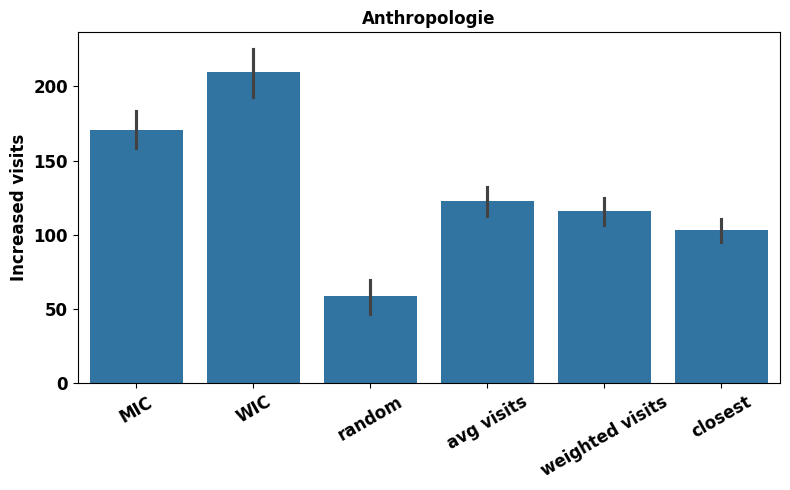

In [42]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = exmple_1_web_design
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews.png'))


Exponential Reviews

In [43]:
k = 7
top_selected_w = neib_centrality_reviews.sort_values('weighted_influence_exp', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_reviews.sort_values('influence_exp', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_reviews_exp.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_reviews_exp.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_reviews_exp.sort_values('weighted_visits', ascending =False).index[:k].values
num_inf = ranked_dic_reviews_exp.sort_values('num_inf', ascending = False).index[:k].values
num_inf_visits = ranked_dic_reviews_exp.sort_values('num_inf_visits', ascending =False).index[:k].values

visits_rage = [0.0109, 0.0509] # mean is 3.09 #https://martech.org/report-cost-to-drive-store-visits-varies-widely-by-category-mobile-most-efficient-channel/
exmple_1_web_design = []


def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits_exp.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_reviews.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    exmple_1_web_design.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])
    
exmple_1_web_design = pd.DataFrame(exmple_1_web_design, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])

exmple_1_web_design.mean()
exmple_1_web_design['type'] = 'example_1_web_design'
exmple_1_web_design

,top_cent_visits,top_w_cent_visits,random_visits,most_avg_visits_inf,closest_weighted_inf,closest_distance_inf,type
0,65.969143,127.554441,19.419730,75.339848,116.878086,79.546949,example_1_web_design
1,30.979163,59.899669,13.426189,35.379654,54.886044,37.355312,example_1_web_design
2,57.499170,111.177350,49.389210,65.666742,101.871764,69.333682,example_1_web_design
3,77.592438,150.028627,37.439605,88.614194,137.471174,93.562557,example_1_web_design
4,58.766949,113.628659,35.407875,67.114605,104.117897,70.862395,example_1_web_design
...,...,...,...,...,...,...,...
95,19.553265,37.807157,13.256545,22.330743,34.642683,23.577728,example_1_web_design
96,67.862134,131.214628,46.950626,77.501732,120.231914,81.829557,example_1_web_design
97,37.380238,72.276448,12.636406,42.689980,66.226882,45.073860,example_1_web_design
98,28.192631,54.511779,35.502161,32.197304,49.949122,33.995255,example_1_web_design


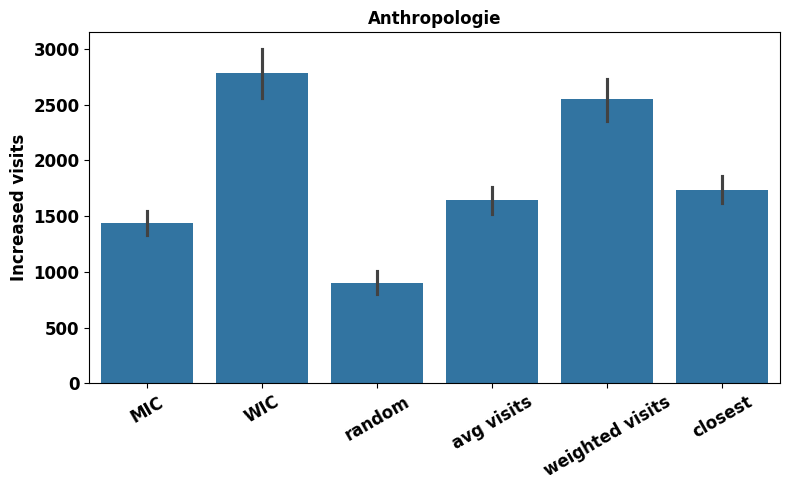

In [44]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = exmple_1_web_design
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))


Linear Visits

In [45]:
k = 7
top_selected_w = neib_centrality_visits.sort_values('weighted_influence', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_visits.sort_values('influence', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_visits.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_visits.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_visits.sort_values('weighted_visits', ascending =False).index[:k].values
num_inf = ranked_dic_visits.sort_values('num_inf', ascending = False).index[:k].values
num_inf_visits = ranked_dic_visits.sort_values('num_inf_visits', ascending =False).index[:k].values

visits_rage = [0.0109, 0.0509] # mean is 3.09 #https://martech.org/report-cost-to-drive-store-visits-varies-widely-by-category-mobile-most-efficient-channel/
exmple_1_web_design = []


def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_visits.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    exmple_1_web_design.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])
    
exmple_1_web_design = pd.DataFrame(exmple_1_web_design, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])

exmple_1_web_design.mean()
exmple_1_web_design['type'] = 'example_1_web_design'
exmple_1_web_design

,top_cent_visits,top_w_cent_visits,random_visits,most_avg_visits_inf,closest_weighted_inf,closest_distance_inf,type
0,29.488621,29.934391,1.265871,1.762793,1.920223,1.553748,example_1_web_design
1,98.878775,100.373494,-12.207372,5.910852,6.438731,5.209898,example_1_web_design
2,109.189730,110.840317,64.554110,6.527228,7.110154,5.753179,example_1_web_design
3,83.643952,84.908372,1.756090,5.000133,5.446678,4.407179,example_1_web_design
4,77.898287,79.075851,12.131247,4.656664,5.072535,4.104441,example_1_web_design
...,...,...,...,...,...,...,...
95,29.403817,29.848305,1.619287,1.757724,1.914701,1.549280,example_1_web_design
96,87.871583,89.199910,6.235105,5.252855,5.721971,4.629931,example_1_web_design
97,61.522686,62.452705,33.749865,3.677751,4.006199,3.241615,example_1_web_design
98,63.391913,64.350189,4.922165,3.789491,4.127918,3.340104,example_1_web_design


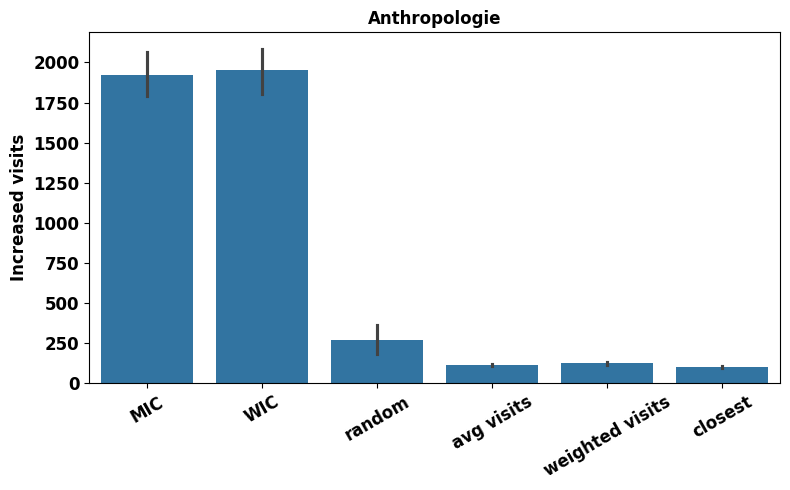

In [46]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = exmple_1_web_design
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits.png'))

Exponential Visits

In [47]:
k = 7
top_selected_w = neib_centrality_visits.sort_values('weighted_influence_exp', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_visits.sort_values('influence_exp', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_visits_exp.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_visits_exp.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_visits_exp.sort_values('weighted_visits', ascending =False).index[:k].values
num_inf = ranked_dic_visits_exp.sort_values('num_inf', ascending = False).index[:k].values
num_inf_visits = ranked_dic_visits_exp.sort_values('num_inf_visits', ascending =False).index[:k].values

visits_rage = [0.0109, 0.0509] # mean is 3.09 #https://martech.org/report-cost-to-drive-store-visits-varies-widely-by-category-mobile-most-efficient-channel/
exmple_1_web_design = []


def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits_exp.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_visits.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    exmple_1_web_design.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])
    
exmple_1_web_design = pd.DataFrame(exmple_1_web_design, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])

exmple_1_web_design.mean()
exmple_1_web_design['type'] = 'example_1_web_design'
exmple_1_web_design

,top_cent_visits,top_w_cent_visits,random_visits,most_avg_visits_inf,closest_weighted_inf,closest_distance_inf,type
0,31.071891,135.840992,24.375850,89.861077,111.810184,89.407363,example_1_web_design
1,36.175407,158.152690,34.003195,104.620636,130.174854,104.092400,example_1_web_design
2,39.043227,170.690308,20.552078,112.914479,140.494518,112.344367,example_1_web_design
3,11.996128,52.445019,11.455757,34.693253,43.167288,34.518085,example_1_web_design
4,30.173085,131.911563,18.848000,87.261694,108.575887,86.821105,example_1_web_design
...,...,...,...,...,...,...,...
95,24.878882,108.766216,35.550114,71.950662,89.525043,71.587379,example_1_web_design
96,31.280181,136.751598,67.385303,90.463458,112.559700,90.006702,example_1_web_design
97,46.224594,202.086014,28.984279,133.683261,166.336200,133.008286,example_1_web_design
98,21.657549,94.683100,15.840590,62.634446,77.933286,62.318201,example_1_web_design


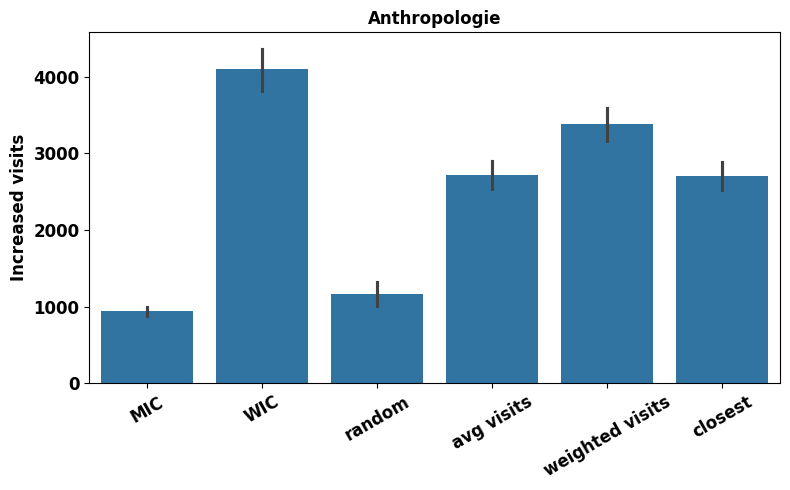

In [48]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = exmple_1_web_design
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))

### Example 2 Choose Partner

Create the folder to save the results

In [49]:
dir_path = os.path.join('example2_choose_partner', brand)
os.makedirs(dir_path, exist_ok=True)

Linear Reviews

In [50]:
visits_rage = [0.0203, 0.0603]#[0.1, 0.2]
k = 1

top_selected_w = neib_centrality_reviews.sort_values('weighted_influence', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_reviews.sort_values('influence', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_reviews.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_reviews.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_reviews.sort_values('weighted_visits', ascending =False).index[:k].values

example_2_partner_choice = []

def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_reviews.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    example_2_partner_choice.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])


example_2_partner_choice = pd.DataFrame(example_2_partner_choice, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])
example_2_partner_choice.mean()
example_2_partner_choice['type'] = 'example_2_partner_choice'
example_2_partner_choice

,top_cent_visits,top_w_cent_visits,random_visits,most_avg_visits_inf,closest_weighted_inf,closest_distance_inf,type
0,1.994575,3.112475,-1.051319,1.064892,1.064892,0.723148,example_2_partner_choice
1,1.137034,1.774307,0.099743,0.607056,0.607056,0.412240,example_2_partner_choice
2,1.195411,1.865403,0.536411,0.638223,0.638223,0.433405,example_2_partner_choice
3,1.949145,3.041582,0.072378,1.040637,1.040637,0.706677,example_2_partner_choice
4,1.372077,2.141085,-0.013655,0.732544,0.732544,0.497457,example_2_partner_choice
...,...,...,...,...,...,...,...
95,1.559298,2.433238,-0.218609,0.832500,0.832500,0.565335,example_2_partner_choice
96,1.658921,2.588696,0.770288,0.885688,0.885688,0.601454,example_2_partner_choice
97,1.981519,3.092102,1.164051,1.057922,1.057922,0.718414,example_2_partner_choice
98,1.064960,1.661839,1.661839,0.568576,0.568576,0.386109,example_2_partner_choice


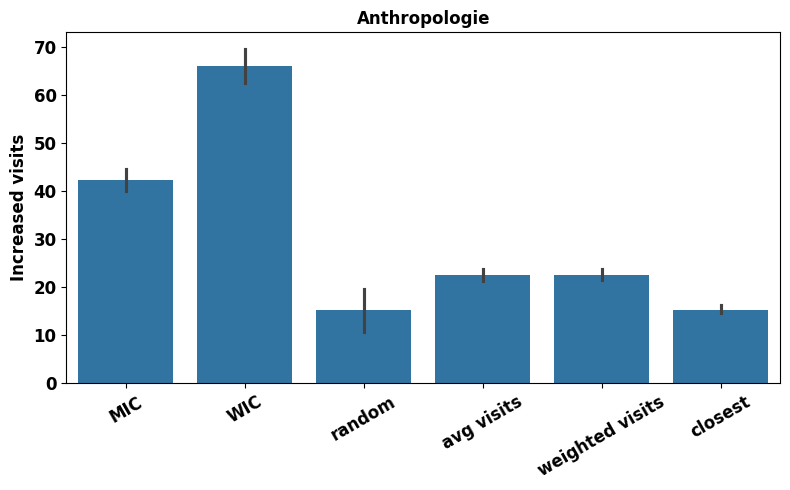

In [51]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = example_2_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']#%/ 3200 * 100
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews.png'))

Exponential Reviews

In [52]:
visits_rage = [0.0203, 0.0603]#[0.1, 0.2]
k = 1

top_selected_w = neib_centrality_reviews.sort_values('weighted_influence_exp', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_reviews.sort_values('influence_exp', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_reviews_exp.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_reviews_exp.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_reviews_exp.sort_values('weighted_visits', ascending =False).index[:k].values

example_2_partner_choice = []

def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits_exp.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_reviews.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    example_2_partner_choice.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])


example_2_partner_choice = pd.DataFrame(example_2_partner_choice, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])
example_2_partner_choice.mean()
example_2_partner_choice['type'] = 'example_2_partner_choice'
example_2_partner_choice

,top_cent_visits,top_w_cent_visits,random_visits,most_avg_visits_inf,closest_weighted_inf,closest_distance_inf,type
0,3.080293,21.111200,13.408480,3.040371,3.040371,10.366940,example_2_partner_choice
1,5.026148,34.447372,3.502954,4.961006,4.961006,16.915849,example_2_partner_choice
2,1.804022,12.364101,3.153776,1.780640,1.780640,6.071559,example_2_partner_choice
3,2.191287,15.018274,0.026705,2.162886,2.162886,7.374927,example_2_partner_choice
4,4.266433,29.240564,14.358975,4.211137,4.211137,14.358975,example_2_partner_choice
...,...,...,...,...,...,...,...
95,2.910336,19.946374,9.722380,2.872616,2.872616,9.794937,example_2_partner_choice
96,3.210799,22.005639,5.222624,3.169185,3.169185,10.806167,example_2_partner_choice
97,3.656116,25.057676,12.213761,3.608730,3.608730,12.304911,example_2_partner_choice
98,2.415532,16.555173,3.080523,2.384226,2.384226,8.129642,example_2_partner_choice


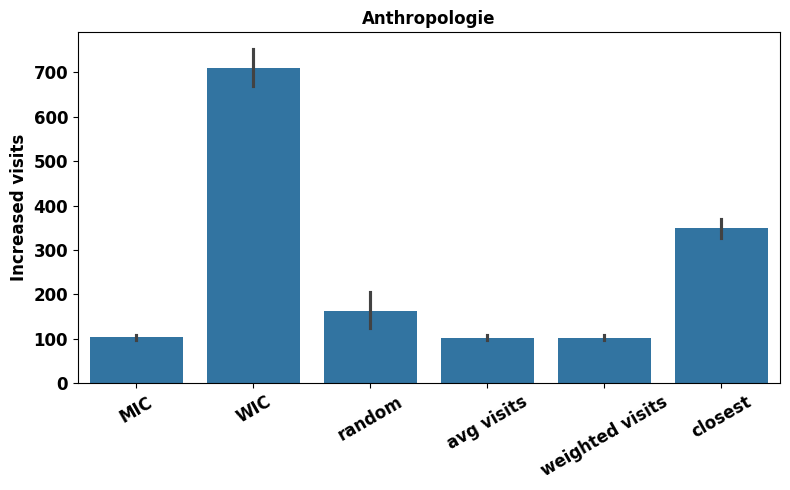

In [53]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = example_2_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']#%/ 3200 * 100
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))

Linear Visits

In [54]:
visits_rage = [0.0203, 0.0603]#[0.1, 0.2]
k = 1

top_selected_w = neib_centrality_visits.sort_values('weighted_influence', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_visits.sort_values('influence', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_visits.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_visits.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_visits.sort_values('weighted_visits', ascending =False).index[:k].values

example_2_partner_choice = []

def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_visits.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    example_2_partner_choice.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])


example_2_partner_choice = pd.DataFrame(example_2_partner_choice, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])
example_2_partner_choice.mean()
example_2_partner_choice['type'] = 'example_2_partner_choice'
example_2_partner_choice

,top_cent_visits,top_w_cent_visits,random_visits,most_avg_visits_inf,closest_weighted_inf,closest_distance_inf,type
0,13.640243,26.782498,0.079465,0.424348,0.424348,0.323667,example_2_partner_choice
1,16.234165,31.875643,-1.134876,0.505045,0.505045,0.385218,example_2_partner_choice
2,15.452059,30.339983,0.366589,0.480714,0.480714,0.366660,example_2_partner_choice
3,31.938840,62.711635,0.907426,0.993618,0.993618,0.757872,example_2_partner_choice
4,20.975096,41.184418,0.520663,0.652536,0.652536,0.497715,example_2_partner_choice
...,...,...,...,...,...,...,...
95,14.114716,27.714121,0.678782,0.439109,0.439109,0.334926,example_2_partner_choice
96,19.890649,39.055117,0.567858,0.618799,0.618799,0.471983,example_2_partner_choice
97,28.281140,55.529773,0.661059,0.879827,0.879827,0.671079,example_2_partner_choice
98,20.097069,39.460421,0.797453,0.625220,0.625220,0.476881,example_2_partner_choice


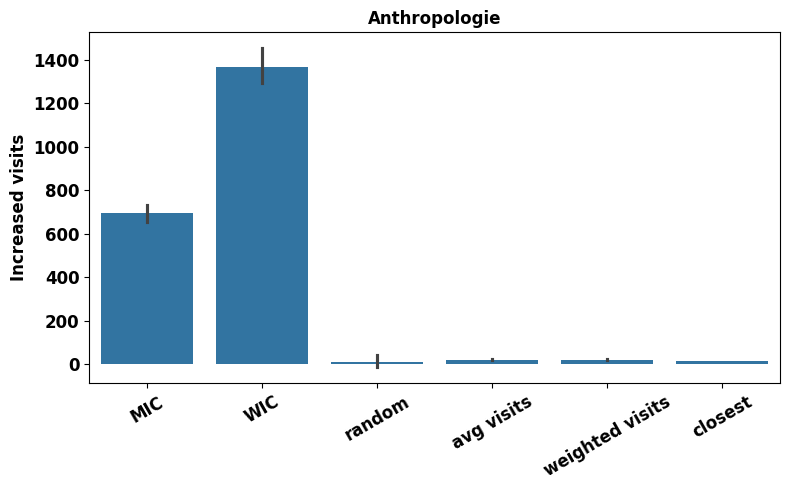

In [55]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = example_2_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']#%/ 3200 * 100
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits.png'))

Exponential Visits

In [56]:
visits_rage = [0.0203, 0.0603]#[0.1, 0.2]
k = 1

top_selected_w = neib_centrality_visits.sort_values('weighted_influence_exp', ascending =False)[:k]['Neib_Brand'].values
top_selected = neib_centrality_visits.sort_values('influence_exp', ascending =False)[:k]['Neib_Brand'].values
most_avg_visits = ranked_dic_visits_exp.sort_values('avg_visits', ascending =False).index[:k].values
closest_distance = ranked_dic_visits_exp.sort_values('distance', ascending = True).index[:k].values
closest_weighted = ranked_dic_visits_exp.sort_values('weighted_visits', ascending =False).index[:k].values

example_2_partner_choice = []

def compute_visits(selected, current_visits_rate):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Neib_Brand.isin(list(selected))]    
    return sub_g.num_inf_visits_exp.sum() * current_visits_rate

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    top_cent_visits = compute_visits(top_selected, current_visits_rate)
    top_w_cent_visits = compute_visits(top_selected_w, current_visits_rate)
    random_selected = random.choices(visits_all_business_pure_visits.Neib_Brand.unique(), k = k)
    random_visits = compute_visits(random_selected, current_visits_rate)
    most_avg_visits_inf = compute_visits(most_avg_visits, current_visits_rate)
    closest_distance_inf = compute_visits(closest_distance, current_visits_rate)
    closest_weighted_inf =compute_visits(closest_weighted, current_visits_rate)
    example_2_partner_choice.append([top_cent_visits, top_w_cent_visits, random_visits, most_avg_visits_inf, closest_weighted_inf, closest_distance_inf])


example_2_partner_choice = pd.DataFrame(example_2_partner_choice, columns = ['top_cent_visits', 'top_w_cent_visits', 'random_visits', 'most_avg_visits_inf', 'closest_weighted_inf', "closest_distance_inf"])
example_2_partner_choice.mean()
example_2_partner_choice['type'] = 'example_2_partner_choice'
example_2_partner_choice

,top_cent_visits,top_w_cent_visits,random_visits,most_avg_visits_inf,closest_weighted_inf,closest_distance_inf,type
0,1.366040,54.730415,0.844604,8.516147,8.516147,13.754792,example_2_partner_choice
1,0.906738,36.328493,-0.580127,5.652776,5.652776,9.130040,example_2_partner_choice
2,0.642081,25.724983,1.055811,4.002852,4.002852,6.465176,example_2_partner_choice
3,0.966179,38.709971,0.039308,6.023338,6.023338,9.728550,example_2_partner_choice
4,1.691097,67.753867,6.529911,10.542618,10.542618,17.027832,example_2_partner_choice
...,...,...,...,...,...,...,...
95,1.083091,43.394070,1.780990,6.752192,6.752192,10.905753,example_2_partner_choice
96,0.782686,31.358349,9.084415,4.879413,4.879413,7.880948,example_2_partner_choice
97,1.727995,69.232168,-0.000002,10.772645,10.772645,17.399358,example_2_partner_choice
98,1.514691,60.686134,2.278450,9.442867,9.442867,15.251577,example_2_partner_choice


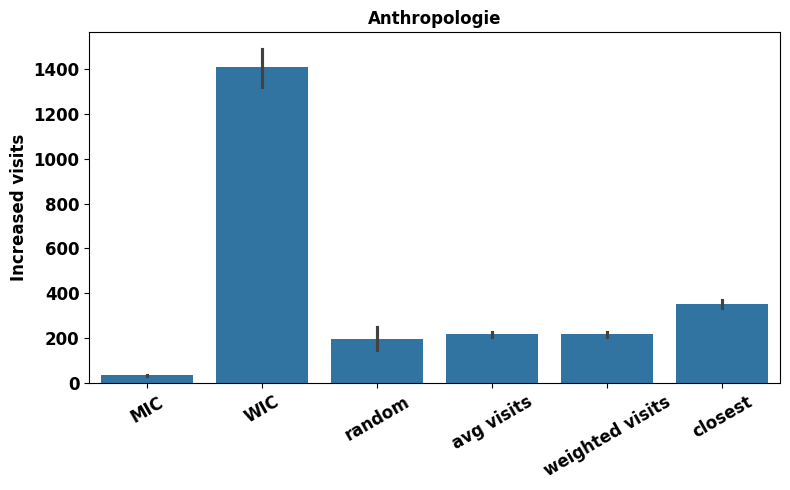

In [57]:
cnt = 0 
DAY = 30 
plt.figure(figsize = (8, 5))

data = example_2_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['value'] = data_sub['value'].astype('float')

data_sub['Increased visits'] = DAY * data_sub['value']#%/ 3200 * 100
sns.barplot(data = data_sub, x = 'variable', y = 'Increased visits')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), ['MIC', 'WIC', 'random', 'avg visits', 'weighted visits', 'closest'], fontsize = 12, rotation = 30, fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))

### Example 4 Inbound Centrality Budget Allocations

Create the folder to save the results

In [58]:
dir_path = os.path.join('example4_inbound_centrality_budget_allocations', brand)
os.makedirs(dir_path, exist_ok=True)

Linear Reviews

In [59]:
visits_rage = [0.0203, 0.0603] 
k = 5
example_4_budget_allocation = []
avg_visits = visits_all_business_pure_reviews.sort_values('Neib_avg_visits', ascending = False)[:k]
weighted_visits = visits_all_business_pure_reviews.sort_values('weighted_visits', ascending = False)[:k]
closest = visits_all_business_pure_reviews.sort_values('Time_mins_inv', ascending = True)[:k]

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    estimate_based =  visits_all_business_pure_reviews['num_inf_visits'][:k].sum() * current_visits_rate  #(df['num_inf_visits'][:k].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    random_based = np.sum(random.choices(visits_all_business_pure_reviews['num_inf_visits'].values, k = k)) * current_visits_rate #(np.sum(random.choices(df['num_inf_visits'].values, k = k)) * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    avg_visits_profit = np.sum(avg_visits['num_inf_visits']) * current_visits_rate #(avg_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    weighted_visits_profit = np.sum(weighted_visits['num_inf_visits'])  * current_visits_rate #(weighted_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    closest_profit = np.sum(closest['num_inf_visits']) * current_visits_rate  #(closest['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    example_4_budget_allocation.append([estimate_based, random_based, avg_visits_profit, weighted_visits_profit, closest_profit])


example_4_budget_allocation = pd.DataFrame(example_4_budget_allocation, columns = ['top', 'random', 'avg_visits_profit', 'weighted_visits_profit', 'closest_profit'])
example_4_budget_allocation['type'] = 'example_4_budget_allocation'
example_4_budget_allocation

,top,random,avg_visits_profit,weighted_visits_profit,closest_profit,type
0,3.029633,0.212235,0.931220,2.951300,0.018325,example_4_budget_allocation
1,2.693655,0.201386,0.827950,2.624009,0.016293,example_4_budget_allocation
2,2.102285,0.003258,0.646181,2.047929,0.012716,example_4_budget_allocation
3,2.320950,-0.076865,0.713392,2.260940,0.014039,example_4_budget_allocation
4,1.949365,-0.028228,0.599178,1.898963,0.011791,example_4_budget_allocation
...,...,...,...,...,...,...
95,3.948501,0.775804,1.213653,3.846410,0.023883,example_4_budget_allocation
96,1.445094,0.019961,0.444180,1.407731,0.008741,example_4_budget_allocation
97,2.006560,0.217031,0.616758,1.954679,0.012137,example_4_budget_allocation
98,2.855873,0.046873,0.877811,2.782033,0.017274,example_4_budget_allocation


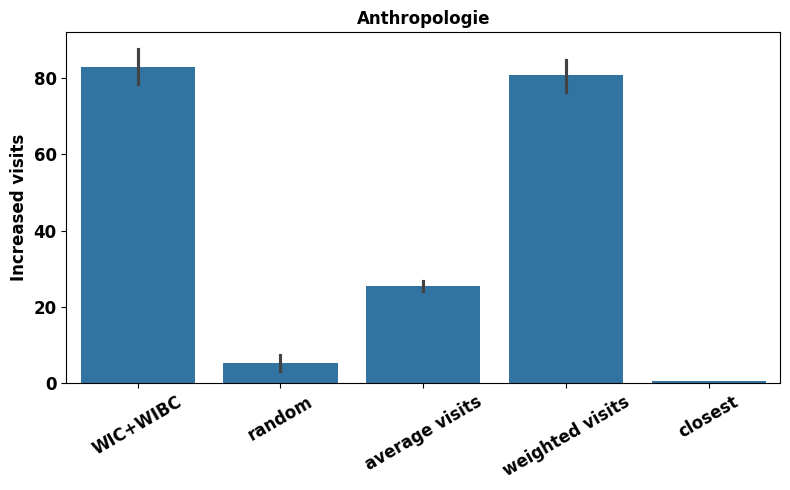

In [60]:
cnt = 0 
DAY = 30
plt.figure(figsize = (8, 5))
data = example_4_budget_allocation      
data_sub = data.melt(value_vars = data.columns[:-1])    

data_sub['Revenue'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(5), [ 'WIC+WIBC', 'random', 'average visits', 'weighted visits', 'closest'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews.png'))

Exponential Reviews

In [61]:
visits_rage = [0.0203, 0.0603] 
k = 5
example_4_budget_allocation = []
avg_visits = visits_all_business_pure_reviews.sort_values('Neib_avg_visits', ascending = False)[:k]
weighted_visits = visits_all_business_pure_reviews.sort_values('weighted_visits', ascending = False)[:k]
closest = visits_all_business_pure_reviews.sort_values('Time_mins_inv_exp', ascending = True)[:k]

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    estimate_based =  visits_all_business_pure_reviews['num_inf_visits_exp'][:k].sum() * current_visits_rate  #(df['num_inf_visits'][:k].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    random_based = np.sum(random.choices(visits_all_business_pure_reviews['num_inf_visits_exp'].values, k = k)) * current_visits_rate #(np.sum(random.choices(df['num_inf_visits'].values, k = k)) * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    avg_visits_profit = np.sum(avg_visits['num_inf_visits_exp']) * current_visits_rate #(avg_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    weighted_visits_profit = np.sum(weighted_visits['num_inf_visits_exp'])  * current_visits_rate #(weighted_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    closest_profit = np.sum(closest['num_inf_visits_exp']) * current_visits_rate  #(closest['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    example_4_budget_allocation.append([estimate_based, random_based, avg_visits_profit, weighted_visits_profit, closest_profit])


example_4_budget_allocation = pd.DataFrame(example_4_budget_allocation, columns = ['top', 'random', 'avg_visits_profit', 'weighted_visits_profit', 'closest_profit'])
example_4_budget_allocation['type'] = 'example_4_budget_allocation'
example_4_budget_allocation

,top,random,avg_visits_profit,weighted_visits_profit,closest_profit,type
0,96.518181,1.166054e-02,5.463747,90.997866,1.978445e-15,example_4_budget_allocation
1,97.895279,1.046994e-07,5.541702,92.296202,2.006673e-15,example_4_budget_allocation
2,73.954542,5.864067e+00,4.186453,69.724745,1.515932e-15,example_4_budget_allocation
3,101.904019,2.582785e-02,5.768631,96.075664,2.088845e-15,example_4_budget_allocation
4,101.485536,-1.829830e-03,5.744941,95.681116,2.080267e-15,example_4_budget_allocation
...,...,...,...,...,...,...
95,124.610306,1.527609e-02,7.053999,117.483275,2.554282e-15,example_4_budget_allocation
96,124.365477,1.896102e+01,7.040139,117.252449,2.549264e-15,example_4_budget_allocation
97,51.010347,1.404988e-09,2.887618,48.092833,1.045618e-15,example_4_budget_allocation
98,126.626719,8.178787e-06,7.168145,119.384360,2.595615e-15,example_4_budget_allocation


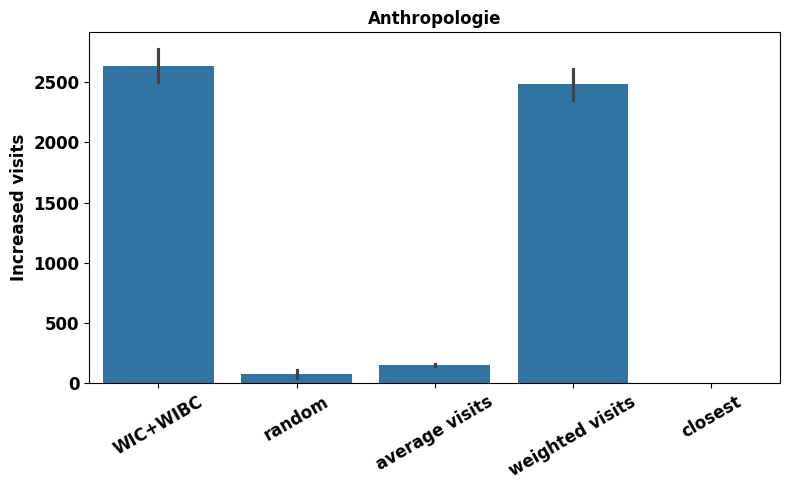

In [62]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_4_budget_allocation      
data_sub = data.melt(value_vars = data.columns[:-1])    

data_sub['Revenue'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(5), [ 'WIC+WIBC', 'random', 'average visits', 'weighted visits', 'closest'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))

Linear Visits

In [63]:
visits_all_business_pure_visits.head()

,Focal_Stores,Neib_Stores,Time_mins,Time_mins_inv,Time_mins_inv_exp,Foc_Brand,Foc_lat,Foc_lon,Foc_avg_visits,Neib_Brand,Neib_avg_visits,Neib_est_review,Neib_est_exp_review,num_inf,num_inf_exp,num_inf_visits,num_inf_visits_exp,weighted_visits,Neib_est_visits,Neib_est_exp_visits
163,zzw-22c@62j-srm-vs5,zzw-22s@62j-srm-vs5,1,1.0,0.367879,Anthropologie,42.301876,-71.383337,788.653846,Windsor,788.653846,0.017681,1.800799,0.017605,1.467884,13.884568,1157.652278,788.653846,0.017605,3.990122
147,zzw-22c@62j-srm-vs5,zzw-225@62j-srm-vvf,2,0.5,0.135335,Anthropologie,42.301876,-71.383337,788.653846,Ruby Thai Kitchen,788.653846,0.039215,0.624793,0.017995,1.008472,14.191781,795.335213,394.326923,0.035990,7.451655
155,zzw-22c@62j-srm-vs5,zzw-23b@62j-srj-ffz,1,1.0,0.367879,Anthropologie,42.301876,-71.383337,788.653846,Aéropostale,788.653846,0.017147,1.377626,0.017048,0.623570,13.444694,491.780638,788.653846,0.017048,1.695038
166,zzw-22c@62j-srm-vs5,246-222@62j-srj-fcq,1,1.0,0.367879,Anthropologie,42.301876,-71.383337,788.653846,Torrid,788.653846,0.017167,1.508622,0.017030,0.621363,13.431063,490.040089,788.653846,0.017030,1.689039
135,zzw-22c@62j-srm-vs5,zzw-22m@62j-srm-vs5,1,1.0,0.367879,Anthropologie,42.301876,-71.383337,788.653846,Zumiez,788.653846,0.017127,1.210350,0.017248,0.563942,13.602811,444.755258,788.653846,0.017248,1.532954


In [64]:
visits_rage = [0.0203, 0.0603]
k = 5
example_4_budget_allocation = []
avg_visits = visits_all_business_pure_visits.sort_values('Neib_avg_visits', ascending = False)[:k]
weighted_visits = visits_all_business_pure_visits.sort_values('weighted_visits', ascending = False)[:k]
closest = visits_all_business_pure_visits.sort_values('Time_mins_inv', ascending = True)[:k]

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    estimate_based =  visits_all_business_pure_visits['num_inf_visits'][:k].sum() * current_visits_rate  #(df['num_inf_visits'][:k].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    random_based = np.sum(random.choices(visits_all_business_pure_visits['num_inf_visits'].values, k = k)) * current_visits_rate #(np.sum(random.choices(df['num_inf_visits'].values, k = k)) * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    avg_visits_profit = np.sum(avg_visits['num_inf_visits']) * current_visits_rate #(avg_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    weighted_visits_profit = np.sum(weighted_visits['num_inf_visits'])  * current_visits_rate #(weighted_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    closest_profit = np.sum(closest['num_inf_visits']) * current_visits_rate  #(closest['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    example_4_budget_allocation.append([estimate_based, random_based, avg_visits_profit, weighted_visits_profit, closest_profit])


example_4_budget_allocation = pd.DataFrame(example_4_budget_allocation, columns = ['top', 'random', 'avg_visits_profit', 'weighted_visits_profit', 'closest_profit'])
example_4_budget_allocation['type'] = 'example_4_budget_allocation'
example_4_budget_allocation

,top,random,avg_visits_profit,weighted_visits_profit,closest_profit,type
0,1.705274,0.065041,0.521267,1.682455,0.198154,example_4_budget_allocation
1,3.251003,0.119861,0.993765,3.207501,0.377770,example_4_budget_allocation
2,3.734081,1.162094,1.141431,3.684114,0.433904,example_4_budget_allocation
3,2.827091,0.840454,0.864183,2.789261,0.328511,example_4_budget_allocation
4,3.891834,-0.898700,1.189653,3.839756,0.452235,example_4_budget_allocation
...,...,...,...,...,...,...
95,3.237095,0.194617,0.989513,3.193778,0.376153,example_4_budget_allocation
96,1.713177,0.915519,0.523683,1.690252,0.199073,example_4_budget_allocation
97,2.296483,-0.439436,0.701988,2.265753,0.266854,example_4_budget_allocation
98,2.664546,0.115289,0.814497,2.628891,0.309623,example_4_budget_allocation


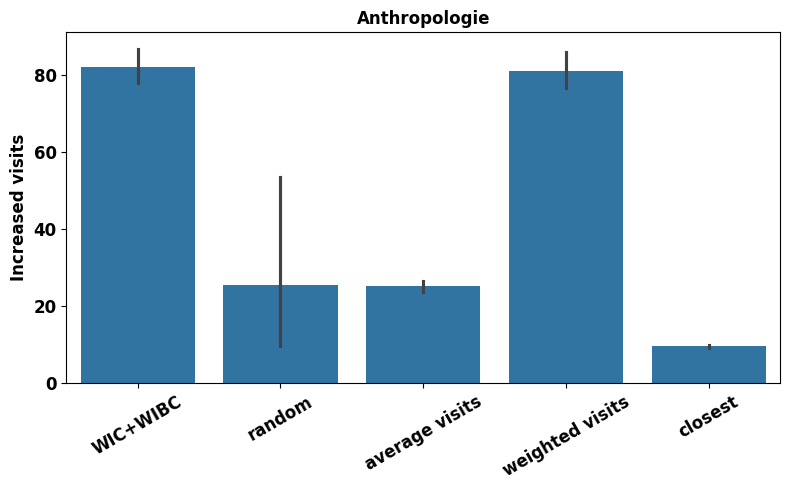

In [65]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_4_budget_allocation      
data_sub = data.melt(value_vars = data.columns[:-1])    

data_sub['Revenue'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(5), [ 'WIC+WIBC', 'random', 'average visits', 'weighted visits', 'closest'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits.png'))

Exponential Visits

In [66]:
visits_rage = [0.0203, 0.0603]
k = 5
example_4_budget_allocation = []
avg_visits = visits_all_business_pure_visits.sort_values('Neib_avg_visits', ascending = False)[:k]
weighted_visits = visits_all_business_pure_visits.sort_values('weighted_visits', ascending = False)[:k]
closest = visits_all_business_pure_visits.sort_values('Time_mins_inv_exp', ascending = True)[:k]

for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    estimate_based =  visits_all_business_pure_visits['num_inf_visits_exp'][:k].sum() * current_visits_rate  #(df['num_inf_visits'][:k].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    random_based = np.sum(random.choices(visits_all_business_pure_visits['num_inf_visits_exp'].values, k = k)) * current_visits_rate #(np.sum(random.choices(df['num_inf_visits'].values, k = k)) * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    avg_visits_profit = np.sum(avg_visits['num_inf_visits_exp']) * current_visits_rate #(avg_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    weighted_visits_profit = np.sum(weighted_visits['num_inf_visits_exp'])  * current_visits_rate #(weighted_visits['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    closest_profit = np.sum(closest['num_inf_visits_exp']) * current_visits_rate  #(closest['num_inf_visits'].sum() * current_visits_rate * consumer_spending - k * budget ) / k * budget  * 100 
    example_4_budget_allocation.append([estimate_based, random_based, avg_visits_profit, weighted_visits_profit, closest_profit])


example_4_budget_allocation = pd.DataFrame(example_4_budget_allocation, columns = ['top', 'random', 'avg_visits_profit', 'weighted_visits_profit', 'closest_profit'])
example_4_budget_allocation['type'] = 'example_4_budget_allocation'
example_4_budget_allocation

,top,random,avg_visits_profit,weighted_visits_profit,closest_profit,type
0,100.271648,1.756190e-05,3.665665,86.624437,-1.157186e-13,example_4_budget_allocation
1,184.024548,1.297262e-02,6.727448,158.978366,-2.123737e-13,example_4_budget_allocation
2,163.349613,2.547426e-06,5.971627,141.117339,-1.885138e-13,example_4_budget_allocation
3,190.751475,1.044310e-01,6.973367,164.789742,-2.201369e-13,example_4_budget_allocation
4,76.000595,5.342349e-05,2.778380,65.656732,-8.770857e-14,example_4_budget_allocation
...,...,...,...,...,...,...
95,153.721936,1.856557e-09,5.619665,132.800012,-1.774030e-13,example_4_budget_allocation
96,121.224106,4.801469e-05,4.431631,104.725215,-1.398988e-13,example_4_budget_allocation
97,95.934357,5.286318e-01,3.507105,82.877461,-1.107131e-13,example_4_budget_allocation
98,80.009573,7.395488e-02,2.924937,69.120079,-9.233513e-14,example_4_budget_allocation


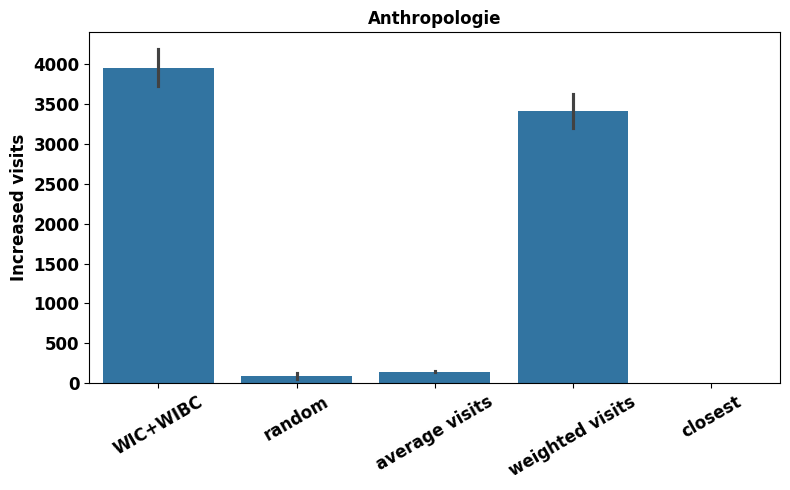

In [67]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_4_budget_allocation
data_sub = data.melt(value_vars = data.columns[:-1])    

data_sub['Revenue'] = DAY * data_sub['value']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue')
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.xticks(range(5), [ 'WIC+WIBC', 'random', 'average visits', 'weighted visits', 'closest'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.xlabel('')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))

### Example 3: Inbound Centrality for Local Marketing Partnerships

Creating a folder to save results

In [68]:
dir_path = os.path.join('example4_inbound_centrality_local_marketing', brand)
os.makedirs(dir_path, exist_ok=True)

Linear Reviews

In [69]:
focal_store_chosen_num = 1
#%%
# https://coresight.com/research/going-head-to-head-in-beauty-retailing-a-comparison-of-sephora-and-ulta/
ranked_dic = visits_all_business_pure_reviews.groupby('Focal_Stores').agg(num_neighbors=('Neib_Stores', 'count'),
                                                   focal_avg_visits=('Foc_avg_visits', 'mean'),
                                                   neighbor_avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits = ('weighted_visits', 'sum')
                                                )

#%%

top_selected_w = inner_centrality_reviews.sort_values('weighted_influence', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
top_selected = inner_centrality_reviews.sort_values('influence', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
num_stores = ranked_dic.sort_values('num_neighbors', ascending =False).index[:focal_store_chosen_num]
focal_avg_visits = ranked_dic.sort_values('focal_avg_visits', ascending =False).index[:focal_store_chosen_num]
avg_visits = ranked_dic.sort_values('neighbor_avg_visits', ascending =False).index[:focal_store_chosen_num]
weighted_visits = ranked_dic.sort_values('weighted_visits', ascending =False).index[:focal_store_chosen_num]


def compute_visits_eg3(store_id, current_visits_rate, num_neighboring_store = 3):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Focal_Stores.isin(store_id)]
    #sub_g = sub_g.sort_values('weighted_visits', ascending = False).reset_index()#[:num_neighboring_store]
    visits = 0 
    for i in range(sub_g.shape[0]):
        visits += sub_g['num_inf_visits'].values[i] 
    return visits * current_visits_rate


### a single collaborator store 
example_3_local_partner_choice = []
for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    random_selected = random.choice(ranked_dic.index)
    rand_profit = compute_visits_eg3([random_selected], current_visits_rate)
    top_selected_w_profit = compute_visits_eg3(top_selected_w, current_visits_rate)
    top_selected_profit = compute_visits_eg3(top_selected, current_visits_rate)
    num_stores_profit = compute_visits_eg3(num_stores, current_visits_rate)
    focal_avg_visits_profit = compute_visits_eg3(focal_avg_visits, current_visits_rate)
    avg_visits_prift = compute_visits_eg3(avg_visits, current_visits_rate)
    closest_weighted_profit = compute_visits_eg3(weighted_visits, current_visits_rate)
    example_3_local_partner_choice.append([rand_profit, top_selected_profit, top_selected_w_profit,  num_stores_profit, focal_avg_visits_profit, avg_visits_prift, closest_weighted_profit])


example_3_local_partner_choice = pd.DataFrame( example_3_local_partner_choice , columns =['rand_profit', 'top_selected_profit', 'top_selected_w_profit', 'num_stores_profit', 'focal_avg_visits_profit', "avg_visits_prift", "closest_weighted_profit"])
example_3_local_partner_choice['type'] = 'example_3_local_partner_choice'

example_3_local_partner_choice

,rand_profit,top_selected_profit,top_selected_w_profit,num_stores_profit,focal_avg_visits_profit,avg_visits_prift,closest_weighted_profit,type
0,0.905345,9.184931,9.184931,-0.044979,9.184931,9.184931,9.184931,example_3_local_partner_choice
1,18.414741,18.414741,18.414741,-0.090178,18.414741,18.414741,18.414741,example_3_local_partner_choice
2,2.047648,20.773858,20.773858,-0.101731,20.773858,20.773858,20.773858,example_3_local_partner_choice
3,1.308467,13.274692,13.274692,-0.065007,13.274692,13.274692,13.274692,example_3_local_partner_choice
4,-0.051427,10.501545,10.501545,-0.051427,10.501545,10.501545,10.501545,example_3_local_partner_choice
...,...,...,...,...,...,...,...,...
95,1.052556,10.678425,10.678425,-0.052293,10.678425,10.678425,10.678425,example_3_local_partner_choice
96,-0.451043,17.634039,17.634039,-0.086355,17.634039,17.634039,17.634039,example_3_local_partner_choice
97,-0.088505,18.073090,18.073090,-0.088505,18.073090,18.073090,18.073090,example_3_local_partner_choice
98,12.701616,12.701616,12.701616,-0.062201,12.701616,12.701616,12.701616,example_3_local_partner_choice


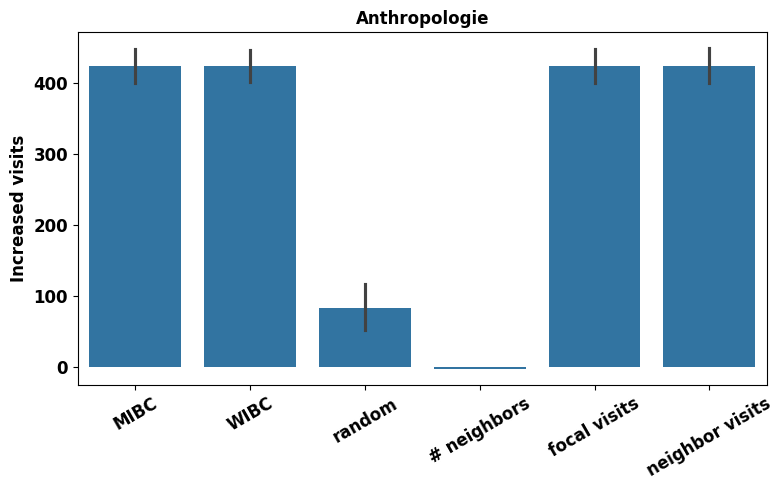

In [70]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_3_local_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['Revenue'] = DAY * (data_sub['value']) #/ 4000 * 100
order = ['top_selected_profit', 'top_selected_w_profit', 'rand_profit', 'num_stores_profit', 
            'focal_avg_visits_profit',  'closest_weighted_profit']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue', order=order)
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), [ 'MIBC', 'WIBC', 'random', '# neighbors', 'focal visits', 'neighbor visits'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews.png'))


Exponential Reviews

In [71]:
focal_store_chosen_num = 1
#%%
# https://coresight.com/research/going-head-to-head-in-beauty-retailing-a-comparison-of-sephora-and-ulta/
ranked_dic = visits_all_business_pure_reviews.groupby('Focal_Stores').agg(num_neighbors=('Neib_Stores', 'count'),
                                                   focal_avg_visits=('Foc_avg_visits', 'mean'),
                                                   neighbor_avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits = ('weighted_visits', 'sum')
                                                )

top_selected_w = inner_centrality_reviews.sort_values('weighted_influence_exp', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
top_selected = inner_centrality_reviews.sort_values('influence_exp', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
num_stores = ranked_dic.sort_values('num_neighbors', ascending =False).index[:focal_store_chosen_num]
focal_avg_visits = ranked_dic.sort_values('focal_avg_visits', ascending =False).index[:focal_store_chosen_num]
avg_visits = ranked_dic.sort_values('neighbor_avg_visits', ascending =False).index[:focal_store_chosen_num]
weighted_visits = ranked_dic.sort_values('weighted_visits', ascending =False).index[:focal_store_chosen_num]


def compute_visits_eg3(store_id, current_visits_rate, num_neighboring_store = 3):
    sub_g = visits_all_business_pure_reviews[visits_all_business_pure_reviews.Focal_Stores.isin(store_id)]
    #sub_g = sub_g.sort_values('weighted_visits', ascending = False).reset_index()#[:num_neighboring_store]
    visits = 0 
    for i in range(sub_g.shape[0]):
        visits += sub_g['num_inf_visits_exp'].values[i] 
    return visits * current_visits_rate


### a single collaborator store 
example_3_local_partner_choice = []
for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    random_selected = random.choice(ranked_dic.index)
    rand_profit = compute_visits_eg3([random_selected], current_visits_rate)
    top_selected_w_profit = compute_visits_eg3(top_selected_w, current_visits_rate)
    top_selected_profit = compute_visits_eg3(top_selected, current_visits_rate)
    num_stores_profit = compute_visits_eg3(num_stores, current_visits_rate)
    focal_avg_visits_profit = compute_visits_eg3(focal_avg_visits, current_visits_rate)
    avg_visits_prift = compute_visits_eg3(avg_visits, current_visits_rate)
    closest_weighted_profit = compute_visits_eg3(weighted_visits, current_visits_rate)
    example_3_local_partner_choice.append([rand_profit, top_selected_profit, top_selected_w_profit,  num_stores_profit, focal_avg_visits_profit, avg_visits_prift, closest_weighted_profit])


example_3_local_partner_choice = pd.DataFrame( example_3_local_partner_choice , columns =['rand_profit', 'top_selected_profit', 'top_selected_w_profit', 'num_stores_profit', 'focal_avg_visits_profit', "avg_visits_prift", "closest_weighted_profit"])
example_3_local_partner_choice['type'] = 'example_3_local_partner_choice'

example_3_local_partner_choice

,rand_profit,top_selected_profit,top_selected_w_profit,num_stores_profit,focal_avg_visits_profit,avg_visits_prift,closest_weighted_profit,type
0,0.059498,172.739769,172.739769,0.061791,172.739769,172.739769,172.739769,example_3_local_partner_choice
1,0.081807,237.507731,237.507731,0.084959,237.507731,237.507731,237.507731,example_3_local_partner_choice
2,277.090900,277.090900,277.090900,0.099118,277.090900,277.090900,277.090900,example_3_local_partner_choice
3,0.059331,165.862715,165.862715,0.059331,165.862715,165.862715,165.862715,example_3_local_partner_choice
4,2.110130,235.562768,235.562768,0.084263,235.562768,235.562768,235.562768,example_3_local_partner_choice
...,...,...,...,...,...,...,...,...
95,1.895192,211.568348,211.568348,0.075680,211.568348,211.568348,211.568348,example_3_local_partner_choice
96,0.059676,166.827108,166.827108,0.059676,166.827108,166.827108,166.827108,example_3_local_partner_choice
97,0.266584,215.286326,215.286326,0.077010,215.286326,215.286326,215.286326,example_3_local_partner_choice
98,0.332297,268.354842,268.354842,0.095993,268.354842,268.354842,268.354842,example_3_local_partner_choice


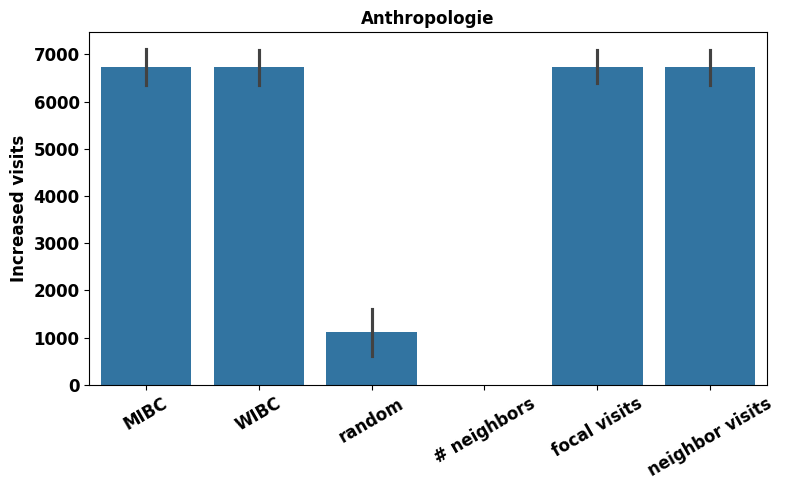

In [72]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_3_local_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['Revenue'] = DAY * (data_sub['value']) #/ 4000 * 100
order = ['top_selected_profit', 'top_selected_w_profit', 'rand_profit', 'num_stores_profit', 
            'focal_avg_visits_profit',  'closest_weighted_profit']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue', order=order)
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), [ 'MIBC', 'WIBC', 'random', '# neighbors', 'focal visits', 'neighbor visits'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'reviews_exp.png'))


Linear Visits

In [73]:
focal_store_chosen_num = 1
#%%
# https://coresight.com/research/going-head-to-head-in-beauty-retailing-a-comparison-of-sephora-and-ulta/
ranked_dic = visits_all_business_pure_visits.groupby('Focal_Stores').agg(num_neighbors=('Neib_Stores', 'count'),
                                                   focal_avg_visits=('Foc_avg_visits', 'mean'),
                                                   neighbor_avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits = ('weighted_visits', 'sum')
                                                )

top_selected_w = inner_centrality_visits.sort_values('weighted_influence', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
top_selected = inner_centrality_visits.sort_values('influence', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
num_stores = ranked_dic.sort_values('num_neighbors', ascending =False).index[:focal_store_chosen_num]
focal_avg_visits = ranked_dic.sort_values('focal_avg_visits', ascending =False).index[:focal_store_chosen_num]
avg_visits = ranked_dic.sort_values('neighbor_avg_visits', ascending =False).index[:focal_store_chosen_num]
weighted_visits = ranked_dic.sort_values('weighted_visits', ascending =False).index[:focal_store_chosen_num]


def compute_visits_eg3(store_id, current_visits_rate, num_neighboring_store = 3):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Focal_Stores.isin(store_id)]
    #sub_g = sub_g.sort_values('weighted_visits', ascending = False).reset_index()#[:num_neighboring_store]
    visits = 0 
    for i in range(sub_g.shape[0]):
        visits += sub_g['num_inf_visits'].values[i] 
    return visits * current_visits_rate


### a single collaborator store 
example_3_local_partner_choice = []
for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    random_selected = random.choice(ranked_dic.index)
    rand_profit = compute_visits_eg3([random_selected], current_visits_rate)
    top_selected_w_profit = compute_visits_eg3(top_selected_w, current_visits_rate)
    top_selected_profit = compute_visits_eg3(top_selected, current_visits_rate)
    num_stores_profit = compute_visits_eg3(num_stores, current_visits_rate)
    focal_avg_visits_profit = compute_visits_eg3(focal_avg_visits, current_visits_rate)
    avg_visits_prift = compute_visits_eg3(avg_visits, current_visits_rate)
    closest_weighted_profit = compute_visits_eg3(weighted_visits, current_visits_rate)
    example_3_local_partner_choice.append([rand_profit, top_selected_profit, top_selected_w_profit,  num_stores_profit, focal_avg_visits_profit, avg_visits_prift, closest_weighted_profit])


example_3_local_partner_choice = pd.DataFrame( example_3_local_partner_choice , columns =['rand_profit', 'top_selected_profit', 'top_selected_w_profit', 'num_stores_profit', 'focal_avg_visits_profit', "avg_visits_prift", "closest_weighted_profit"])
example_3_local_partner_choice['type'] = 'example_3_local_partner_choice'

example_3_local_partner_choice

,rand_profit,top_selected_profit,top_selected_w_profit,num_stores_profit,focal_avg_visits_profit,avg_visits_prift,closest_weighted_profit,type
0,80.583917,80.583917,80.583917,11.105591,80.583917,80.583917,80.583917,example_3_local_partner_choice
1,10.623832,77.088200,77.088200,10.623832,77.088200,77.088200,77.088200,example_3_local_partner_choice
2,5.622063,46.154730,46.154730,6.360767,46.154730,46.154730,46.154730,example_3_local_partner_choice
3,6.231082,71.024840,71.024840,9.788216,71.024840,71.024840,71.024840,example_3_local_partner_choice
4,3.921525,28.455204,28.455204,3.921525,28.455204,28.455204,28.455204,example_3_local_partner_choice
...,...,...,...,...,...,...,...,...
95,2.595582,33.463238,33.463238,4.611702,33.463238,33.463238,33.463238,example_3_local_partner_choice
96,4.066649,46.353608,46.353608,6.388175,46.353608,46.353608,46.353608,example_3_local_partner_choice
97,7.395306,60.712293,60.712293,8.367003,60.712293,60.712293,60.712293,example_3_local_partner_choice
98,3.514093,28.849200,28.849200,3.975823,28.849200,28.849200,28.849200,example_3_local_partner_choice


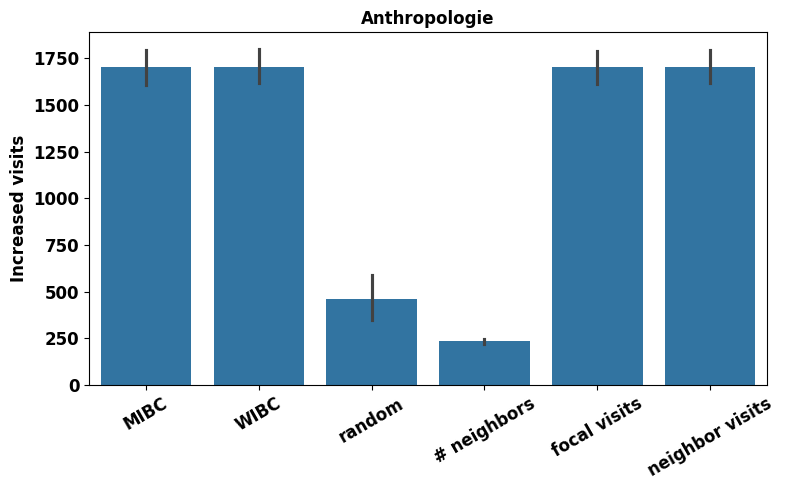

In [74]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_3_local_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['Revenue'] = DAY * (data_sub['value']) #/ 4000 * 100
order = ['top_selected_profit', 'top_selected_w_profit', 'rand_profit', 'num_stores_profit', 
            'focal_avg_visits_profit',  'closest_weighted_profit']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue', order=order)
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), [ 'MIBC', 'WIBC', 'random', '# neighbors', 'focal visits', 'neighbor visits'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits.png'))

Exponential Visits

In [75]:
focal_store_chosen_num = 1
#%%
# https://coresight.com/research/going-head-to-head-in-beauty-retailing-a-comparison-of-sephora-and-ulta/
ranked_dic = visits_all_business_pure_visits.groupby('Focal_Stores').agg(num_neighbors=('Neib_Stores', 'count'),
                                                   focal_avg_visits=('Foc_avg_visits', 'mean'),
                                                   neighbor_avg_visits=('Neib_avg_visits', 'sum'),
                                                   weighted_visits = ('weighted_visits', 'sum')
                                                )

top_selected_w = inner_centrality_visits.sort_values('weighted_influence_exp', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
top_selected = inner_centrality_visits.sort_values('influence_exp', ascending =False)[:focal_store_chosen_num].Focal_Stores.values
num_stores = ranked_dic.sort_values('num_neighbors', ascending =False).index[:focal_store_chosen_num]
focal_avg_visits = ranked_dic.sort_values('focal_avg_visits', ascending =False).index[:focal_store_chosen_num]
avg_visits = ranked_dic.sort_values('neighbor_avg_visits', ascending =False).index[:focal_store_chosen_num]
weighted_visits = ranked_dic.sort_values('weighted_visits', ascending =False).index[:focal_store_chosen_num]


def compute_visits_eg3(store_id, current_visits_rate, num_neighboring_store = 3):
    sub_g = visits_all_business_pure_visits[visits_all_business_pure_visits.Focal_Stores.isin(store_id)]
    #sub_g = sub_g.sort_values('weighted_visits', ascending = False).reset_index()#[:num_neighboring_store]
    visits = 0 
    for i in range(sub_g.shape[0]):
        visits += sub_g['num_inf_visits_exp'].values[i] 
    return visits * current_visits_rate


### a single collaborator store 
example_3_local_partner_choice = []
for rand in range(100):
    current_visits_rate = random.uniform(visits_rage[0], visits_rage[1]) 
    random_selected = random.choice(ranked_dic.index)
    rand_profit = compute_visits_eg3([random_selected], current_visits_rate)
    top_selected_w_profit = compute_visits_eg3(top_selected_w, current_visits_rate)
    top_selected_profit = compute_visits_eg3(top_selected, current_visits_rate)
    num_stores_profit = compute_visits_eg3(num_stores, current_visits_rate)
    focal_avg_visits_profit = compute_visits_eg3(focal_avg_visits, current_visits_rate)
    avg_visits_prift = compute_visits_eg3(avg_visits, current_visits_rate)
    closest_weighted_profit = compute_visits_eg3(weighted_visits, current_visits_rate)
    example_3_local_partner_choice.append([rand_profit, top_selected_profit, top_selected_w_profit,  num_stores_profit, focal_avg_visits_profit, avg_visits_prift, closest_weighted_profit])


example_3_local_partner_choice = pd.DataFrame( example_3_local_partner_choice , columns =['rand_profit', 'top_selected_profit', 'top_selected_w_profit', 'num_stores_profit', 'focal_avg_visits_profit', "avg_visits_prift", "closest_weighted_profit"])
example_3_local_partner_choice['type'] = 'example_3_local_partner_choice'

example_3_local_partner_choice

,rand_profit,top_selected_profit,top_selected_w_profit,num_stores_profit,focal_avg_visits_profit,avg_visits_prift,closest_weighted_profit,type
0,0.148985,372.586694,372.586694,0.148985,372.586694,372.586694,372.586694,example_3_local_partner_choice
1,0.094681,236.779563,236.779563,0.094681,236.779563,236.779563,236.779563,example_3_local_partner_choice
2,24.093179,316.397739,316.397739,0.126517,316.397739,316.397739,316.397739,example_3_local_partner_choice
3,0.087625,349.065103,349.065103,0.139580,349.065103,349.065103,349.065103,example_3_local_partner_choice
4,1.579709,264.381893,264.381893,0.105718,264.381893,264.381893,264.381893,example_3_local_partner_choice
...,...,...,...,...,...,...,...,...
95,0.100288,276.533748,276.533748,0.110577,276.533748,276.533748,276.533748,example_3_local_partner_choice
96,0.089640,247.173234,247.173234,0.098837,247.173234,247.173234,247.173234,example_3_local_partner_choice
97,0.119906,330.626252,330.626252,0.132207,330.626252,330.626252,330.626252,example_3_local_partner_choice
98,33.521993,440.219307,440.219307,0.176030,440.219307,440.219307,440.219307,example_3_local_partner_choice


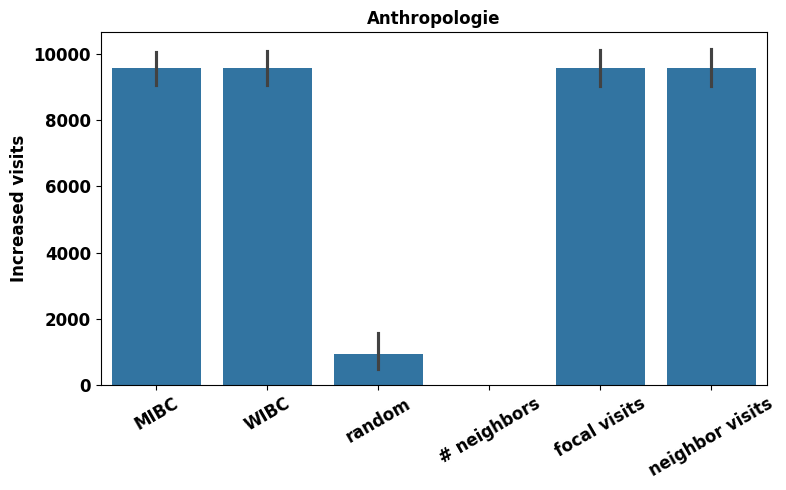

In [76]:
cnt = 0 
plt.figure(figsize = (8, 5))
data = example_3_local_partner_choice
data_sub = data.melt(value_vars = data.columns[:-1])
data_sub['Revenue'] = DAY * (data_sub['value']) #/ 4000 * 100
order = ['top_selected_profit', 'top_selected_w_profit', 'rand_profit', 'num_stores_profit', 
            'focal_avg_visits_profit',  'closest_weighted_profit']
sns.barplot(data = data_sub, x = 'variable', y = 'Revenue', order=order)
plt.title('{}'.format(brand), fontsize = 12, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Increased visits', fontsize = 12, fontweight = 'bold')
plt.xticks(range(6), [ 'MIBC', 'WIBC', 'random', '# neighbors', 'focal visits', 'neighbor visits'], fontsize = 12, fontweight = 'bold', rotation = 30)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'visits_exp.png'))